## CMPINF 2100 - Final project feedback

### Calibrating Additive Manufacturing (AM) simulations

This report gives general feedback from the proposals about the final project. In addition to addressing pitfalls, multiple recommendations are provided to help with performing the analysis for the project.

## Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

## Input data

The inputs are read below.

In [2]:
input_df = pd.read_csv('training_inputs.csv')

In [3]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sim_id  55 non-null     int64  
 1   x1      55 non-null     float64
 2   x2      55 non-null     float64
 3   x3      55 non-null     float64
 4   x4      55 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 2.3 KB


One row in `input_df` corresponds to a simulation of the Additive Manufacturing (AM) process. The `sim_id` variable uniquely defines each simulation and thus each row. The `.nunique()` method confirms `sim_id` has as many unique values as rows in the data.

In [4]:
input_df.nunique()

sim_id    55
x1        55
x2        55
x3        55
x4        55
dtype: int64

The simulation input variables, `x1` though `x4` also have as many unique values as simulations. We can do a quick check of the scales of the inputs to show that `x1` has substantially different scales from the other 3 inputs. It is critical to standardize the inputs before running analyses like cluster analysis.

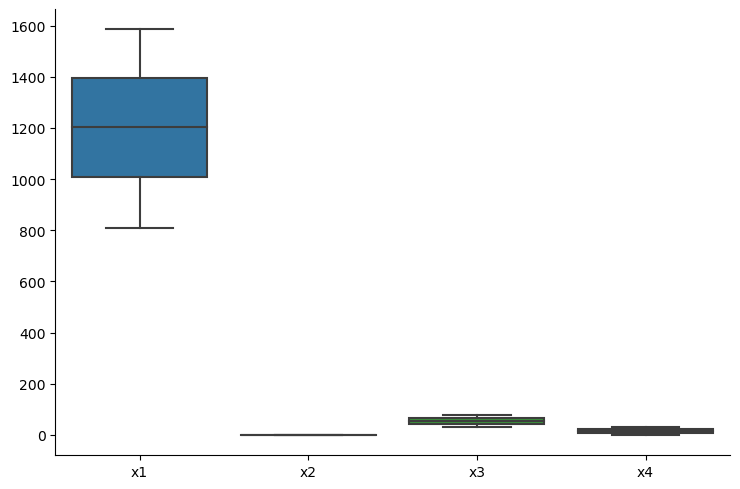

In [5]:
sns.catplot(data = input_df.drop(columns=['sim_id']), kind='box', aspect=1.5)

plt.show()

We should use the input data to answer questions about the relationships between the inputs. We will discuss just why this is so important later when we also consider the output variables. We can use a pairsplot to examine the input marginal distributions and input-to-input scatter plots. Visually, the histograms appear to be Uniform and there does not seem to be any relationship between the inputs.

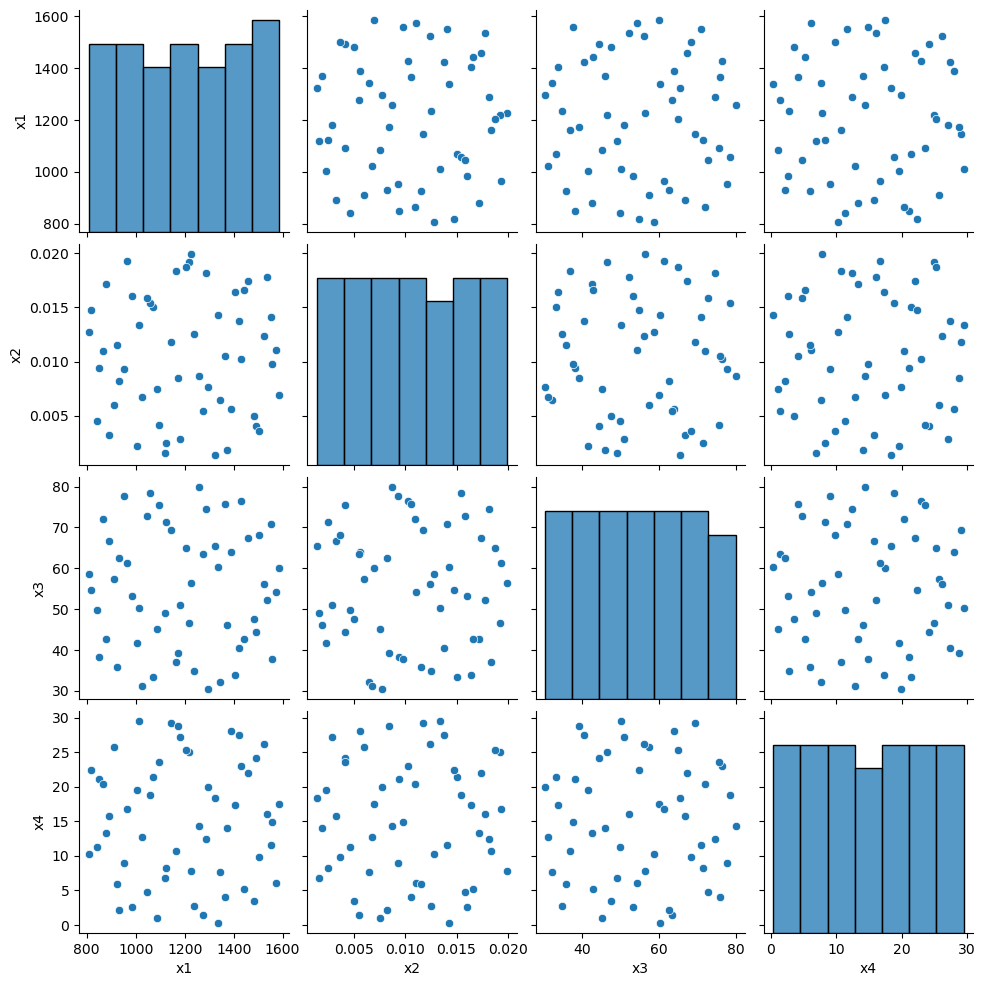

In [7]:
sns.pairplot(data = input_df.drop(columns=['sim_id']) )

plt.show()

A correlation plot can also be used to examine the input-to-input relationships. The correlation plot below shows the correlation coefficients are near 0.

In [8]:
input_names = input_df.drop(columns=['sim_id']).columns.to_list()

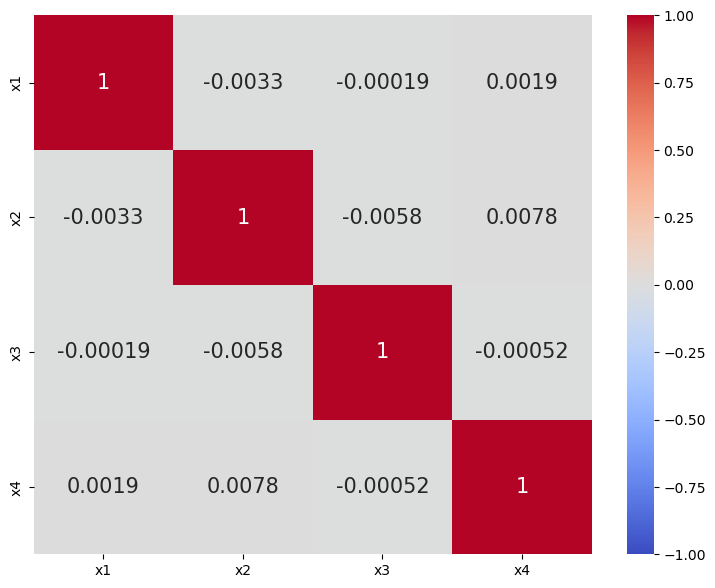

In [9]:
fig, ax = plt.subplots(figsize=(9,7))

sns.heatmap( input_df.loc[:, input_names].corr(), 
            vmin=-1, center=0, vmax=1,
            annot=True, annot_kws={'size': 15},
            cmap='coolwarm',
            ax=ax)

plt.show()

## Output data

The outputs are read in below.

In [10]:
output_df = pd.read_csv('training_outputs.csv')

In [11]:
output_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3300 entries, 0 to 3299
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sim_id     3300 non-null   int64  
 1   layer_id   3300 non-null   int64  
 2   action_id  3300 non-null   int64  
 3   time       3300 non-null   float64
 4   y          3300 non-null   float64
dtypes: float64(2), int64(3)
memory usage: 129.0 KB


The output data are organized in LONG-FORMAT. It can be confusing at first to work with, but the LONG-FORMAT structure is a flexible format for complicated data situations like Additive Manufacturing (AM). 

Before exploring the output variable `y`, we need to first discuss the identifier variables, `sim_id`, `layer_id`, and `action_id`. The `input_df` showed that `sim_id` has 55 unique values. The `.nunique()` method applied `output_df` confirms `sim_id` also has 55 unique values. Thus, even though `output_df` has 3300 rows there are still just 55 unique values to `sim_id` and thus there are 55 simulations in the output data as well.

In [12]:
output_df.nunique()

sim_id         55
layer_id       20
action_id       3
time         3143
y            2243
dtype: int64

The `layer_id` column has 20 unique values whlie `action_id` has 3 unique values. Thus, there are 20 layers and 3 actions. We need to check how many unique layer values exist per simulation and how many unique actions exist per simulation. We can make this check using `.groupby()` and `.aggregate()`. The result is assigned to the `check_ids_per_sim`.

In [13]:
check_ids_per_sim = output_df.groupby(['sim_id']).\
aggregate(num_layers = ('layer_id', 'nunique'),
          num_actions = ('action_id', 'nunique')).\
reset_index()

We can now check the number of layers per simulation. As shown below all 55 simulations have the same number of layers!

In [14]:
check_ids_per_sim.num_layers.value_counts()

20    55
Name: num_layers, dtype: int64

Likewise we can confirm that all 55 simulations have the same number of actions!

In [15]:
check_ids_per_sim.num_actions.value_counts()

3    55
Name: num_actions, dtype: int64

Essentially, the long-format data are organized by "stacking" the outputs from 55 simulations on top of each other. The output, `y`, is the layer temperature at a specific instant in time within a layer. Three instances are required per layer and those instances are denoted by the `action_id` column. Since each simulation consists of 20 layers, a single simulation produces $20 \times 3 = 60$ outputs. Let's confirm this is the case by counting the number of rows associated with `sim_id` value in `output_df`. All bars have the same height of 60!

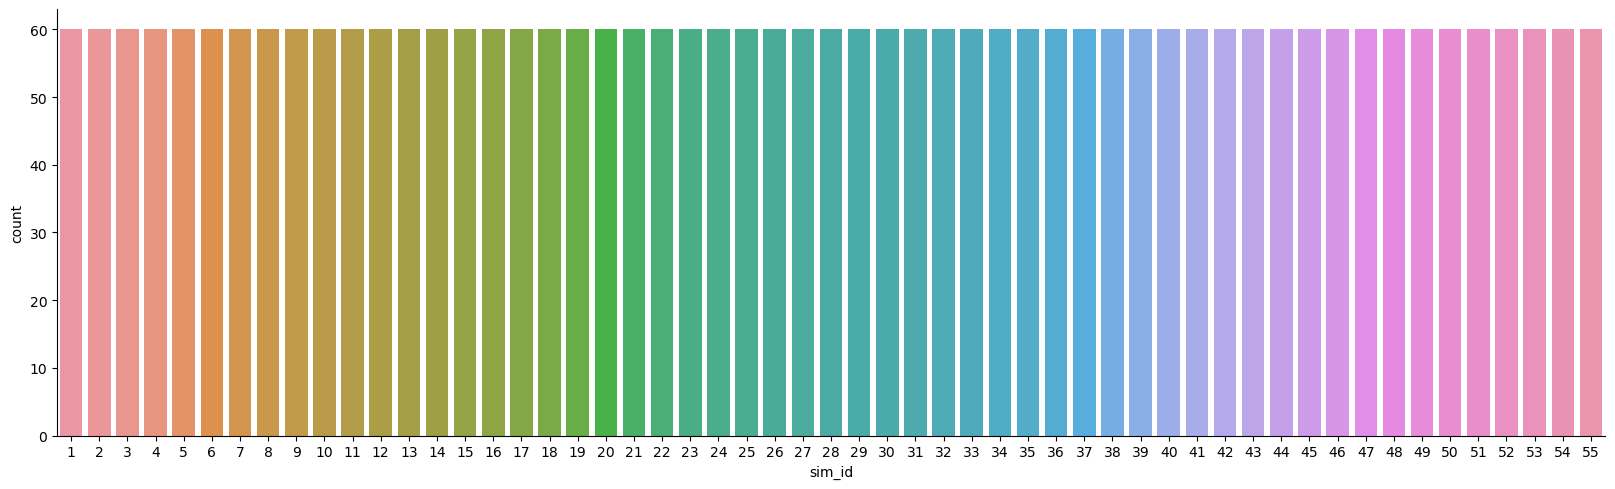

In [16]:
sns.catplot(data = output_df, x='sim_id', kind='count', aspect=3.25)

plt.show()

Grouping by `action_id` reveals that each simulation consists of 20 observations (layers) per `action_id` value!

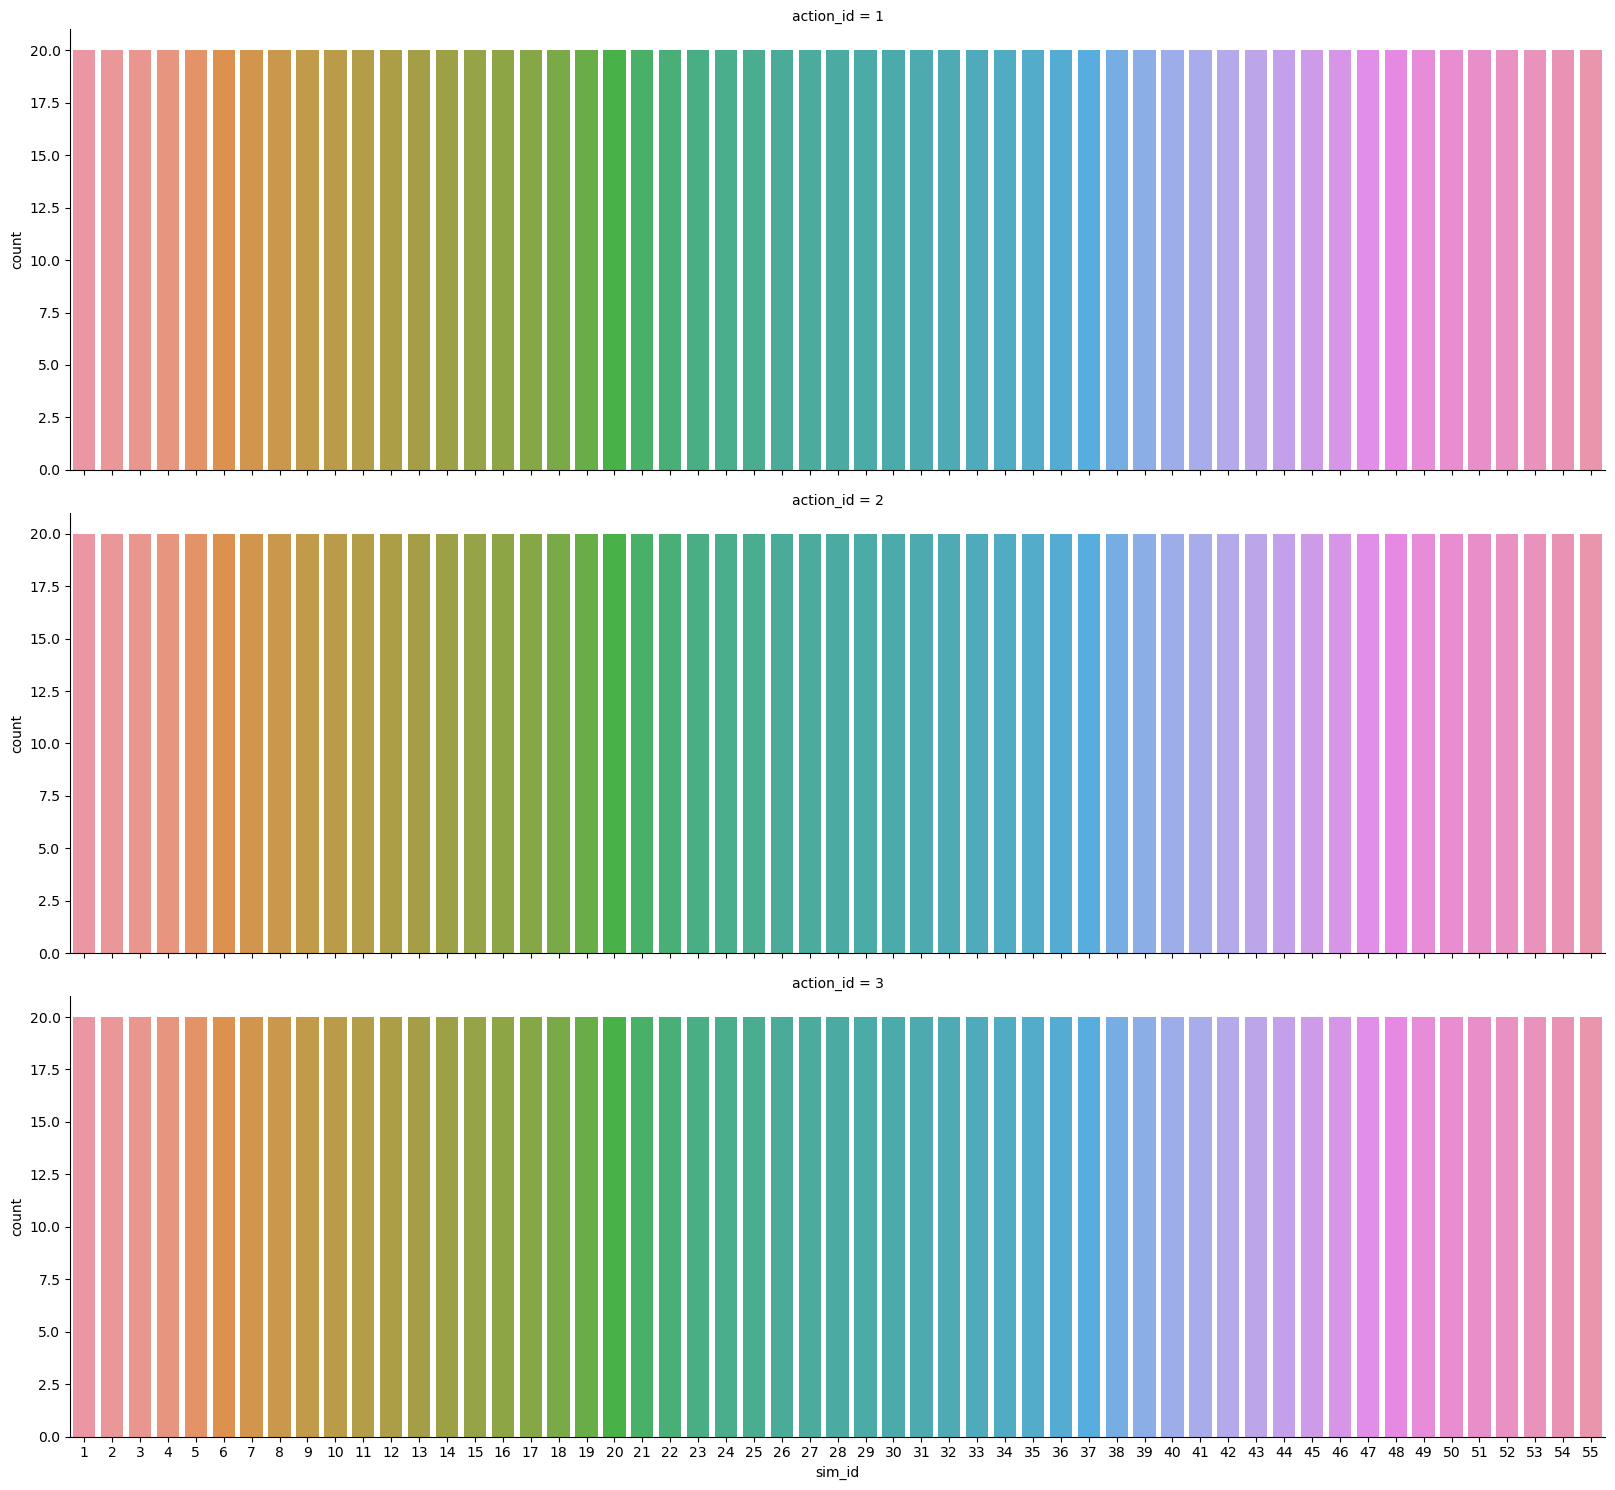

In [17]:
sns.catplot(data = output_df, x='sim_id', row='action_id', kind='count', aspect=3.25)

plt.show()

Identifying the organizational structure is critical because this allows us to properly explore and thus model the output. If we just examine the (marginal) output distribution, "as it is", it will seem like `y` is bimodal. One group of `y` consists of "higher" values above 800, while the lower group consists of values of about 200 or less.

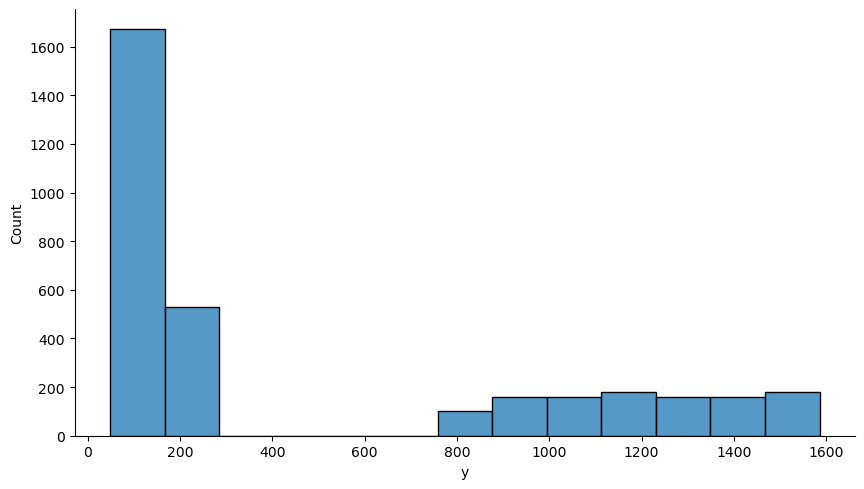

In [19]:
sns.displot(data = output_df, x='y', aspect=1.75)

plt.show()

The above figure however ignores the fact that the `y` variable is specifically associated with 3 instances or actions within each layer. Thus, it is important to respect this structure when exploring the data. The figure below uses facets to denote the `action_id` value. The facets reveal that the higher group of values with `y` between 800 and 1600 only correspond to `action_id = 1`! The other two actions are associated with the lower values!

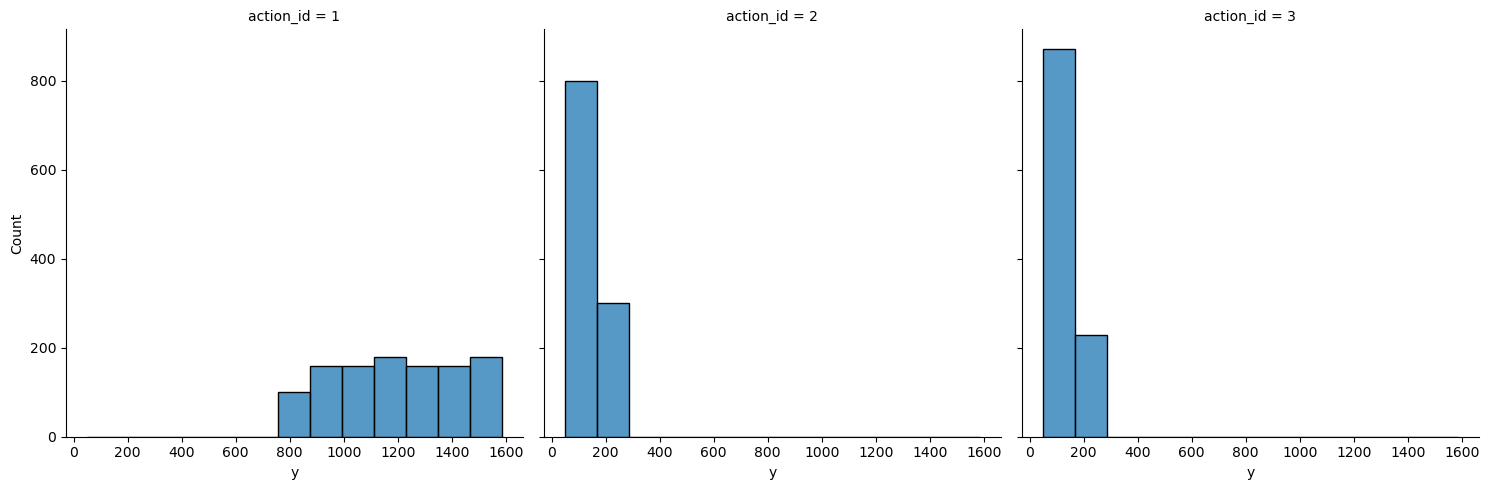

In [20]:
sns.displot(data = output_df, x='y', col='action_id')

plt.show()

By default, the axes are SHARED across all facets. The `facet_kws` argument combined with `common_bins` can be used to let the facets have SEPARATE axis bounds! As shown below, `y` is roughly uniformly distributed when `action_id = 1`, but looks more like a bell curve for `action_id = 2` and `action_id = 3`. The center of the bell is between 100 and 150 for the other two `action_id` values.

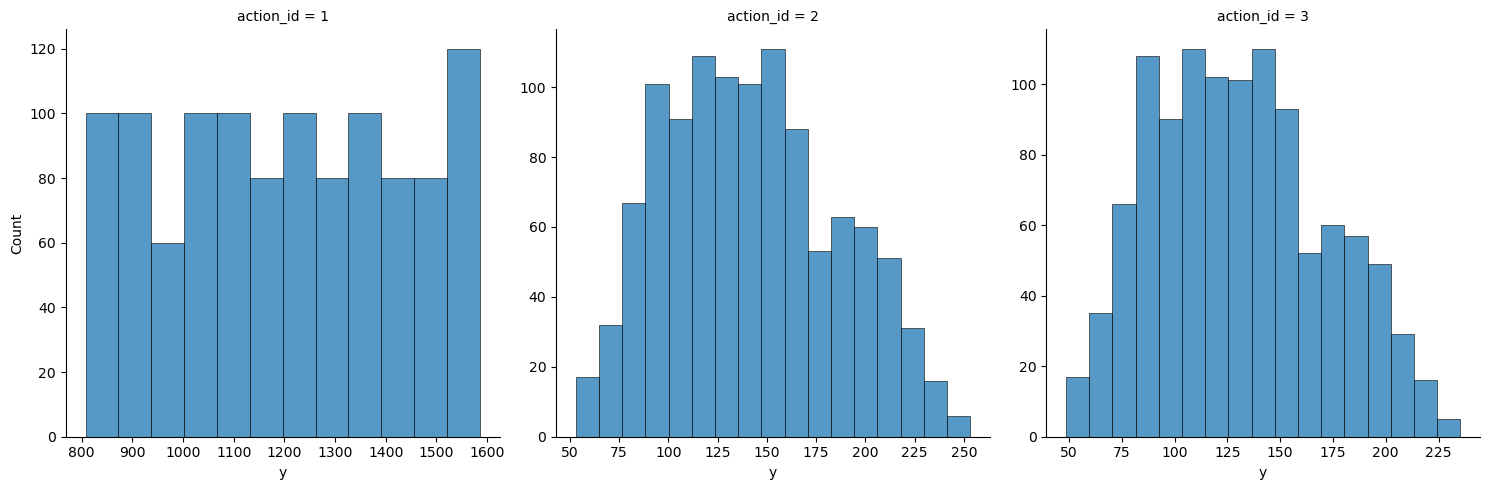

In [21]:
sns.displot(data = output_df, x='y', col='action_id', kind='hist',
            facet_kws={'sharex': False, 'sharey': False},
            common_bins=False)

plt.show()

The output `y` is "time series like". The "main" time-like index for each simulation is the `layer_id`. This tells us the LAYER the observations are associated with within the AM build. However, if we ignore the `action_id` variable we will miss important behavior. Let's first consider the output vs layer relationship for just 4 simulations. The cell below filters `output_df` to just the first 4 simulations.

In [22]:
output_4sims = output_df.loc[ output_df.sim_id < 5, : ].copy()

In [23]:
output_4sims.nunique()

sim_id         4
layer_id      20
action_id      3
time         240
y            164
dtype: int64

The output can be visualized "like a time series" by plotting `y` with respect to `layer_id`. The plot below denotes the 4 simulations via facets to help separate the behavior. However, the plots below look rather strange...

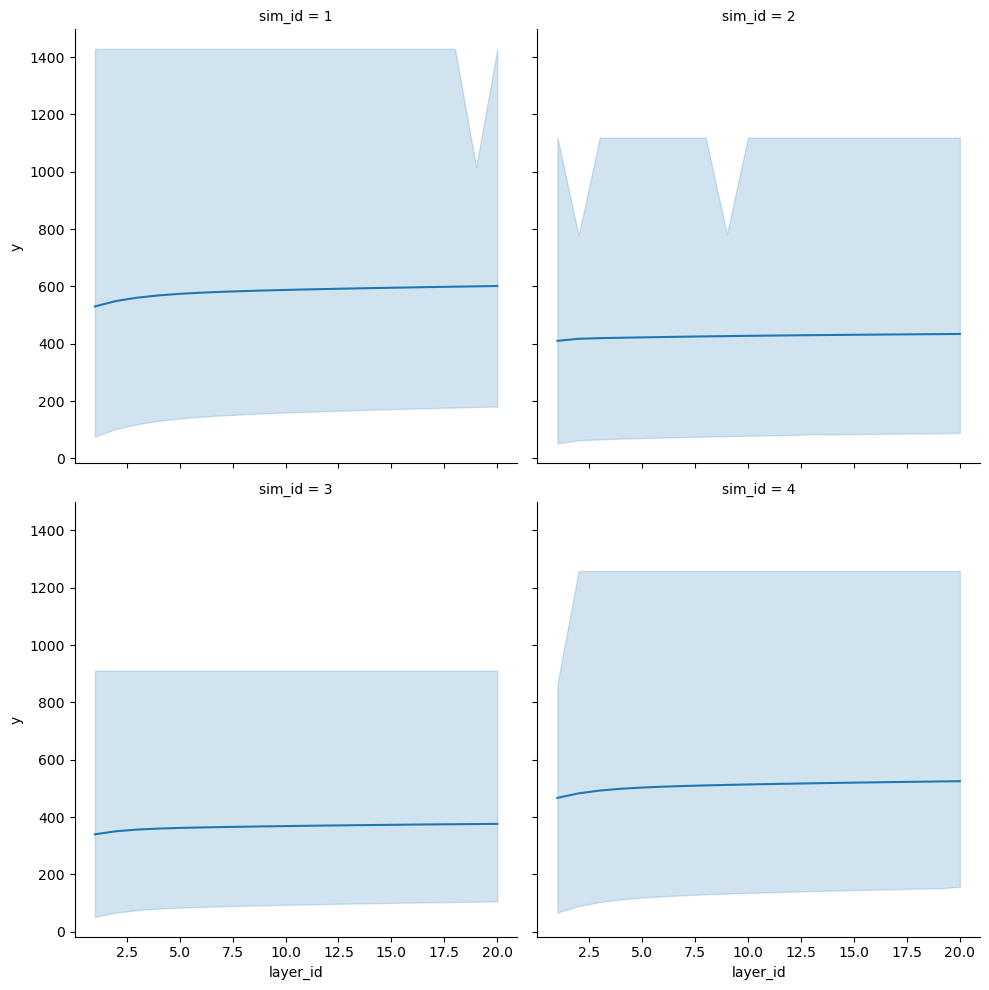

In [24]:
sns.relplot(data = output_4sims, x='layer_id', y='y', col='sim_id', col_wrap=2, kind='line')

plt.show()

The odd behavior is due to the fact that Seaborn wants to summarize line plots by default. The summarization is occuring because 3 actions are recorded at each layer! We can show separate lines per `action_id` value across `layer_id` by specifying `hue='action_id'`. As shown below, each facet includes 3 lines. The data associated with those lines were in the previous figure. The default summary action however "hid" the lines from view. The `estimator` is set to `None` to enforce NO summary actions are executed!

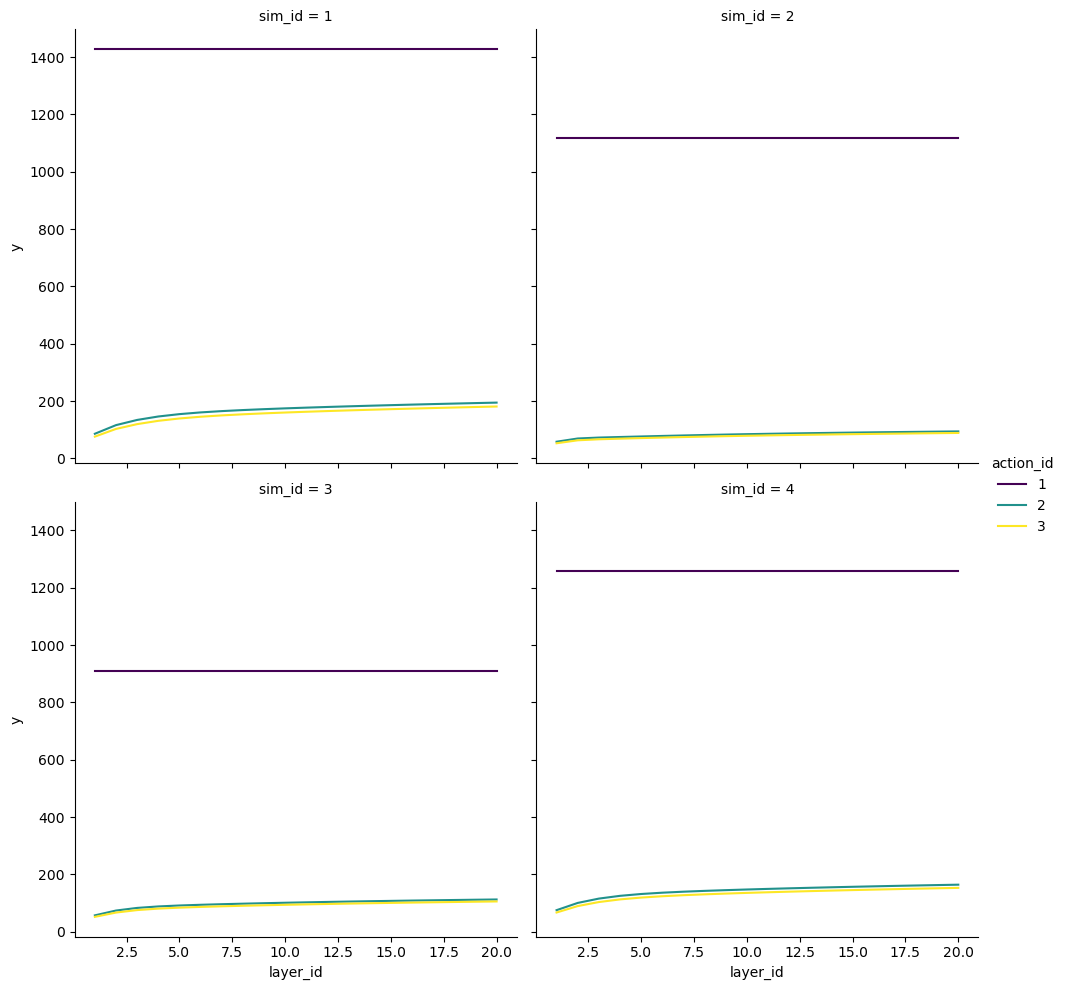

In [37]:
sns.relplot(data = output_4sims, x='layer_id', y='y', hue='action_id', 
            col='sim_id', col_wrap=2, kind='line',
            estimator=None, 
            palette='viridis')

plt.show()

Coloring by `action_id` reveals what we learned from the histograms previously. The `y` values associated with `action_id = 1` are much higher than the values associated with the other two actions. The problem statement for this project discusses that we are primarily interested in the output, `y`, associated with `action_id = 3`. Thus, we do not care as much about the `y` values when `action_id` equals 1 or 2. The cell below isolates the first simulation, `sim_id = 1`, and uses facets with separate y-axis scales. This isolates the behavior associated with the first simulation and lets us see how the `y` variable changes as the `layer_id` increases. The `y` value associated with `action_id = 1` is constant for `sim_id=1`, but the `y` values associated with `action_id` 2 and 3 increase as `layer_id` increases!

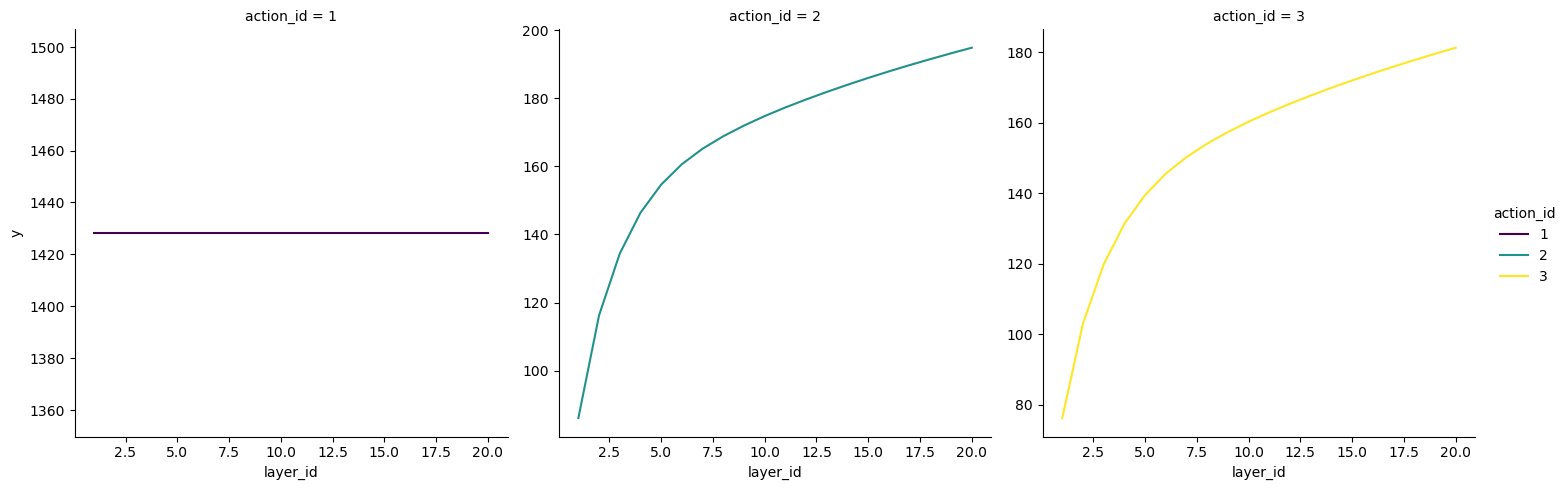

In [38]:
sns.relplot(data = output_4sims.loc[ output_4sims.sim_id == 1, :], 
            x='layer_id', y='y', kind='line',
            hue='action_id', col='action_id',
            estimator=None,
            palette='viridis',
            facet_kws={'sharey': False})

plt.show()

Let's continue visualizing `y` vs `layer_id`, but let's use `hue` to denote the `sim_id` and facets to with separate y-axis scales to denote the `action_id`. The figure below is created with the first 4 simulations.

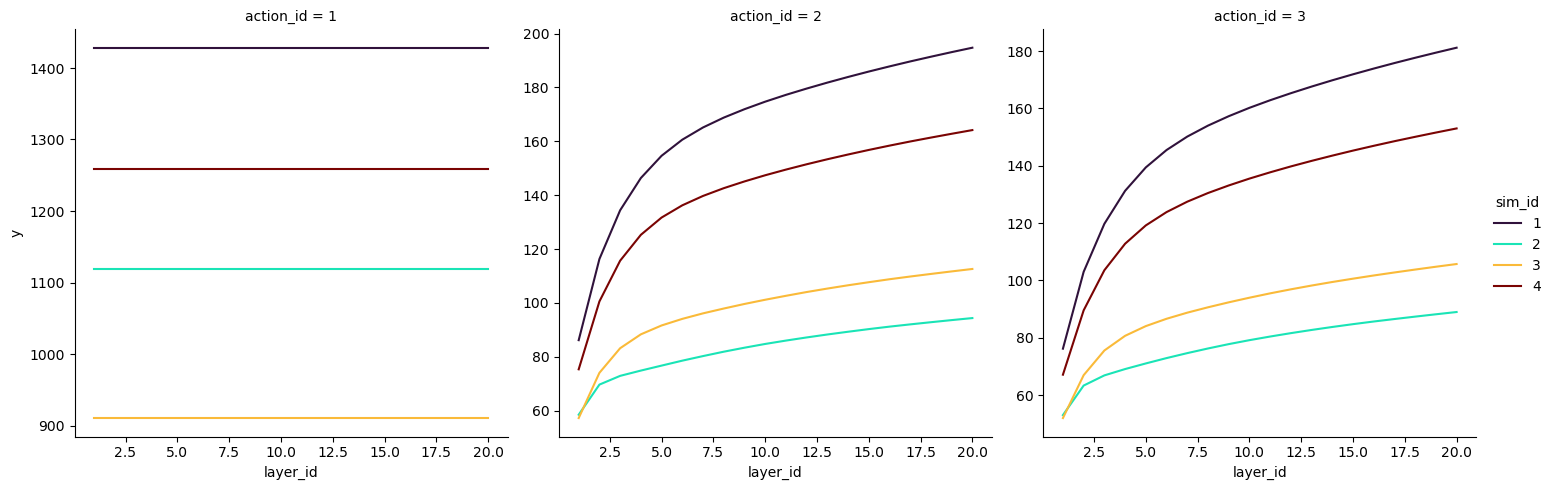

In [39]:
sns.relplot(data = output_4sims, 
            x='layer_id', y='y', kind='line',
            hue='sim_id', col='action_id',
            estimator=None,
            palette='turbo',
            facet_kws={'sharey': False})

plt.show()

But, as stated previously we are primarily interested in the behavior associated with `action_id = 3`. The figure below filters the 4 simulations to just `action_id = 3`. The column facet is included to remind ourselves that we are focusing on `action_id = 3`. The lines reveal that layer temperature, `y`, is not the same across the 4 simulations!

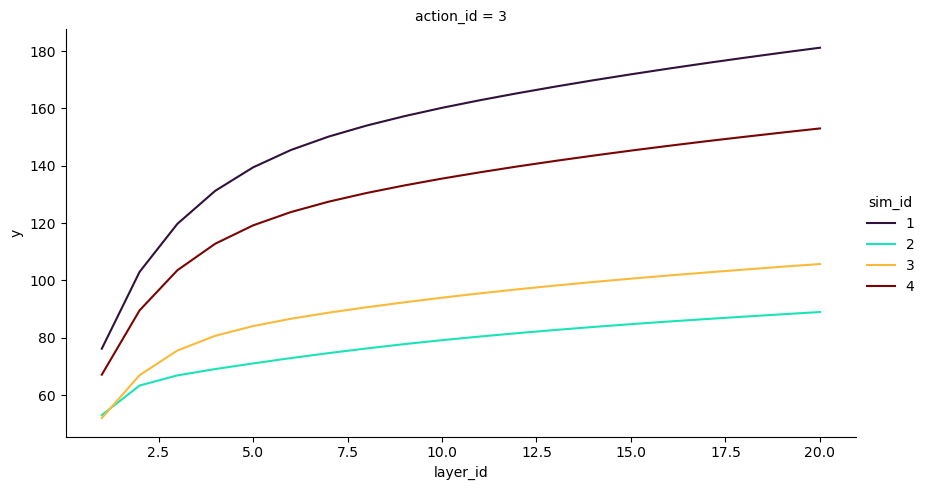

In [41]:
sns.relplot(data = output_4sims.loc[ output_4sims.action_id == 3, :], 
            x='layer_id', y='y', hue='sim_id', col='action_id',
            kind='line',
            estimator=None, 
            palette='turbo',
            aspect=1.75)

plt.show()

The previous figures focused on 4 simulations just to illustrate the concepts. Instead we want to examine the behavior of ALL simulations! The figure below shows separate lines for all 55 simulations.

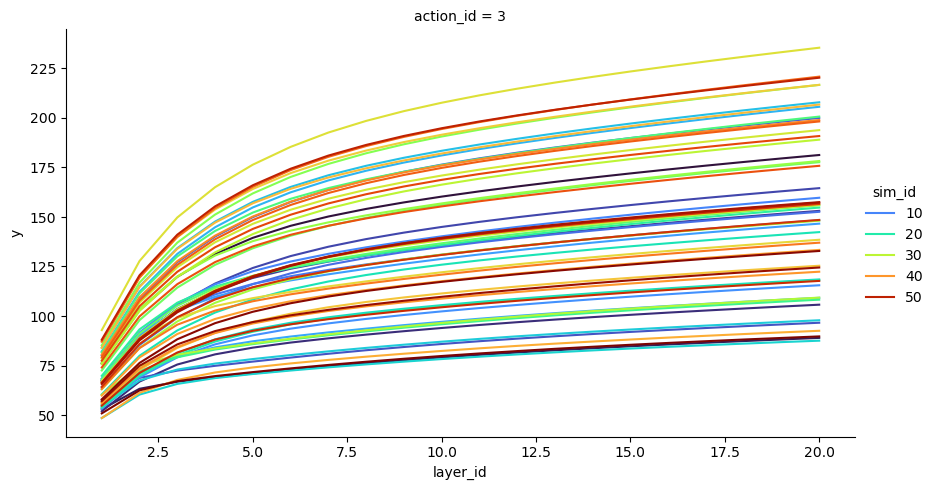

In [42]:
sns.relplot(data = output_df.loc[ output_df.action_id == 3, :], 
            x='layer_id', y='y', hue='sim_id', col='action_id',
            kind='line',
            estimator=None, palette='turbo',
            aspect=1.75)

plt.show()

Filtering the data to just the rows with `action_id = 3` makes it clear that all simulations have roughly the same general behavior. The `y` value increases as `layer_id` increases, and the rate of change (slope) is higher in the earlier layers than later layers. However, the different simulations have different initial values, ending values, and rates of change. **Thus, the goal of the project is to study how the inputs, `x1` through `x4`, influence the behavior of `y` with respect to `layer_id` for `action_id = 3`.**  

However, before examining the relationship with respect to the inputs, it is important to further study the **distribution** of `y` at each `layer_id` across the simulations. The figure below summarizes the `y` distribution at each `layer_id` via boxplots. **You must examine the distribution at each `layer_id` further to check if the distributions are symmetric (Gaussian like).**

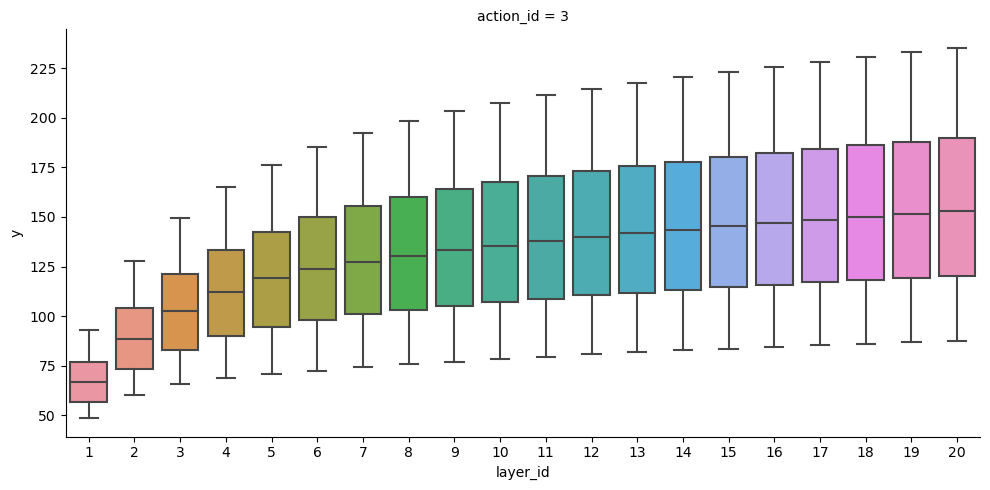

In [43]:
sns.catplot(data = output_df.loc[ output_df.action_id == 3, : ],
            x='layer_id', y = 'y', 
            col='action_id',
            kind='box',
            aspect=2)

plt.show()

## Input-to-output relationships

The `input_df` and `output_df` objects can be merged or joined by the `sim_id` **key**. The merged data has as many rows as `output_df`, but includes the 4 inputs, `x1` through `x4`.

In [44]:
df = output_df.merge( input_df, on=['sim_id'], how='left' )

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3300 entries, 0 to 3299
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sim_id     3300 non-null   int64  
 1   layer_id   3300 non-null   int64  
 2   action_id  3300 non-null   int64  
 3   time       3300 non-null   float64
 4   y          3300 non-null   float64
 5   x1         3300 non-null   float64
 6   x2         3300 non-null   float64
 7   x3         3300 non-null   float64
 8   x4         3300 non-null   float64
dtypes: float64(6), int64(3)
memory usage: 257.8 KB


We previously saw that each input has 55 unique values. That is still the case in the merged data:

In [46]:
df.nunique()

sim_id         55
layer_id       20
action_id       3
time         3143
y            2243
x1             55
x2             55
x3             55
x4             55
dtype: int64

One row in `df` corresponds to an instant (action) in a layer within a simulation. Thus, the inputs are repeated $3 \times 20 = 60$ times. To confirm this, a few `x1` and `sim_id` combinations are summarized below. All `x1` values occur 60 times in the merged data.

In [47]:
df.groupby(['x1', 'sim_id']).size().reset_index(name='num_rows').head()

,x1,sim_id,num_rows
0,807.788620,20,60
1,818.574666,36,60
2,841.630716,38,60
3,848.652481,11,60
4,864.569145,18,60


The merged data allows visualizing the output `y` with respect to a single input. However, we do not want to just make the scatter plot between `y` and the input. As previously discussed we know `action_id` greatly impacts the scale. Instead, we should isolate on a single `action_id` value. Let's continuous to focus on `action_id = 3`. The figure below shows `y` vs `x1` across all simulations and layers.

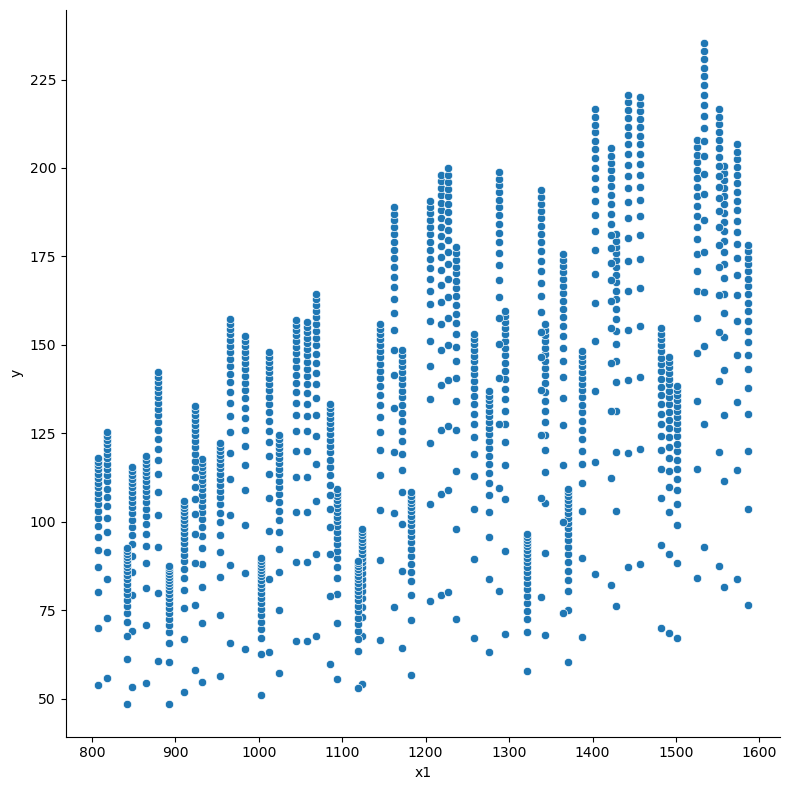

In [48]:
sns.relplot(data = df.loc[ df.action_id == 3, :],
            x='x1', y = 'y',
            kind='scatter',
            height=8)

plt.show()

However, we know that the output `y` changes as `layer_id` changes for each simulation! Thus, we should instead visualize the output `y` vs the input facetted by `layer_id`! This allows us to isolate how the input impacts the output within a layer (at a specific instant of time - the `action_id`). The marker size was manually changed to `s=120` to make the markers easier to see within each facet. In general, it seems that the output `y` increases as `x1` increases within each layer.

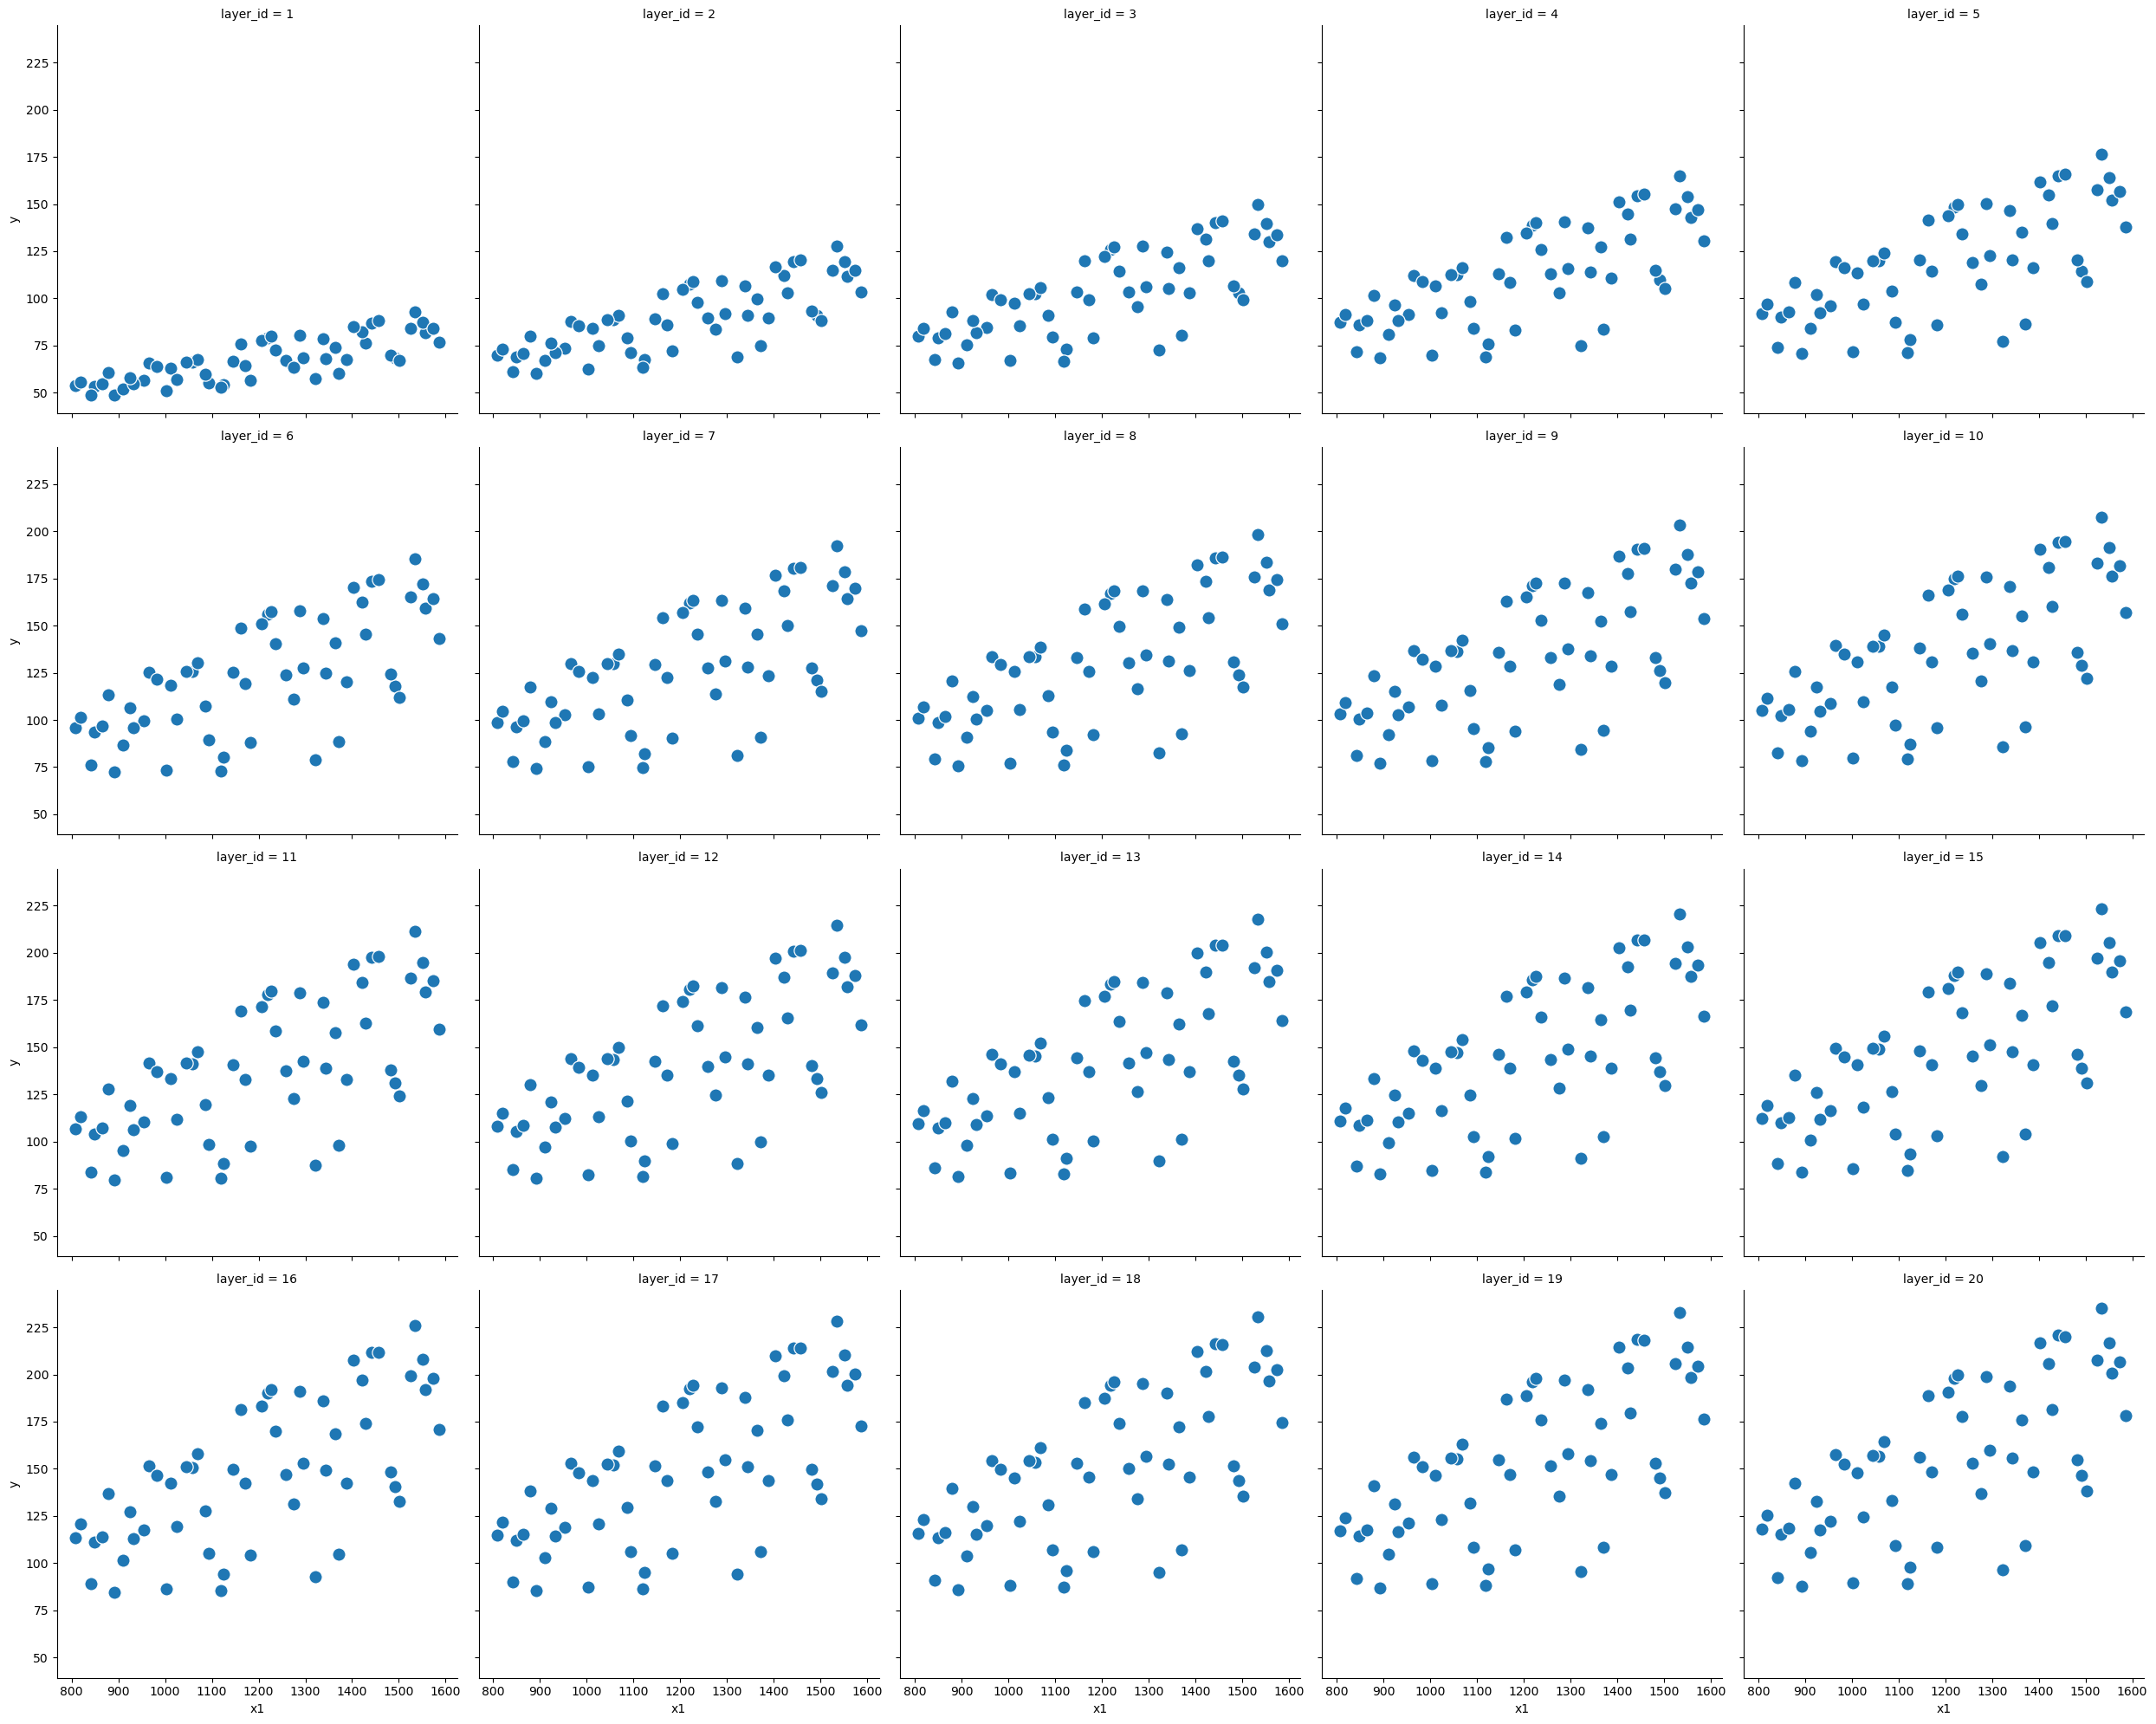

In [49]:
sns.relplot(data = df.loc[ df.action_id == 3, :],
            x='x1', y = 'y',
            kind='scatter', s=120,
            col='layer_id', col_wrap=5)

plt.show()

We can also include a trend line to help identify the basic relationship between the output and input, per facet.

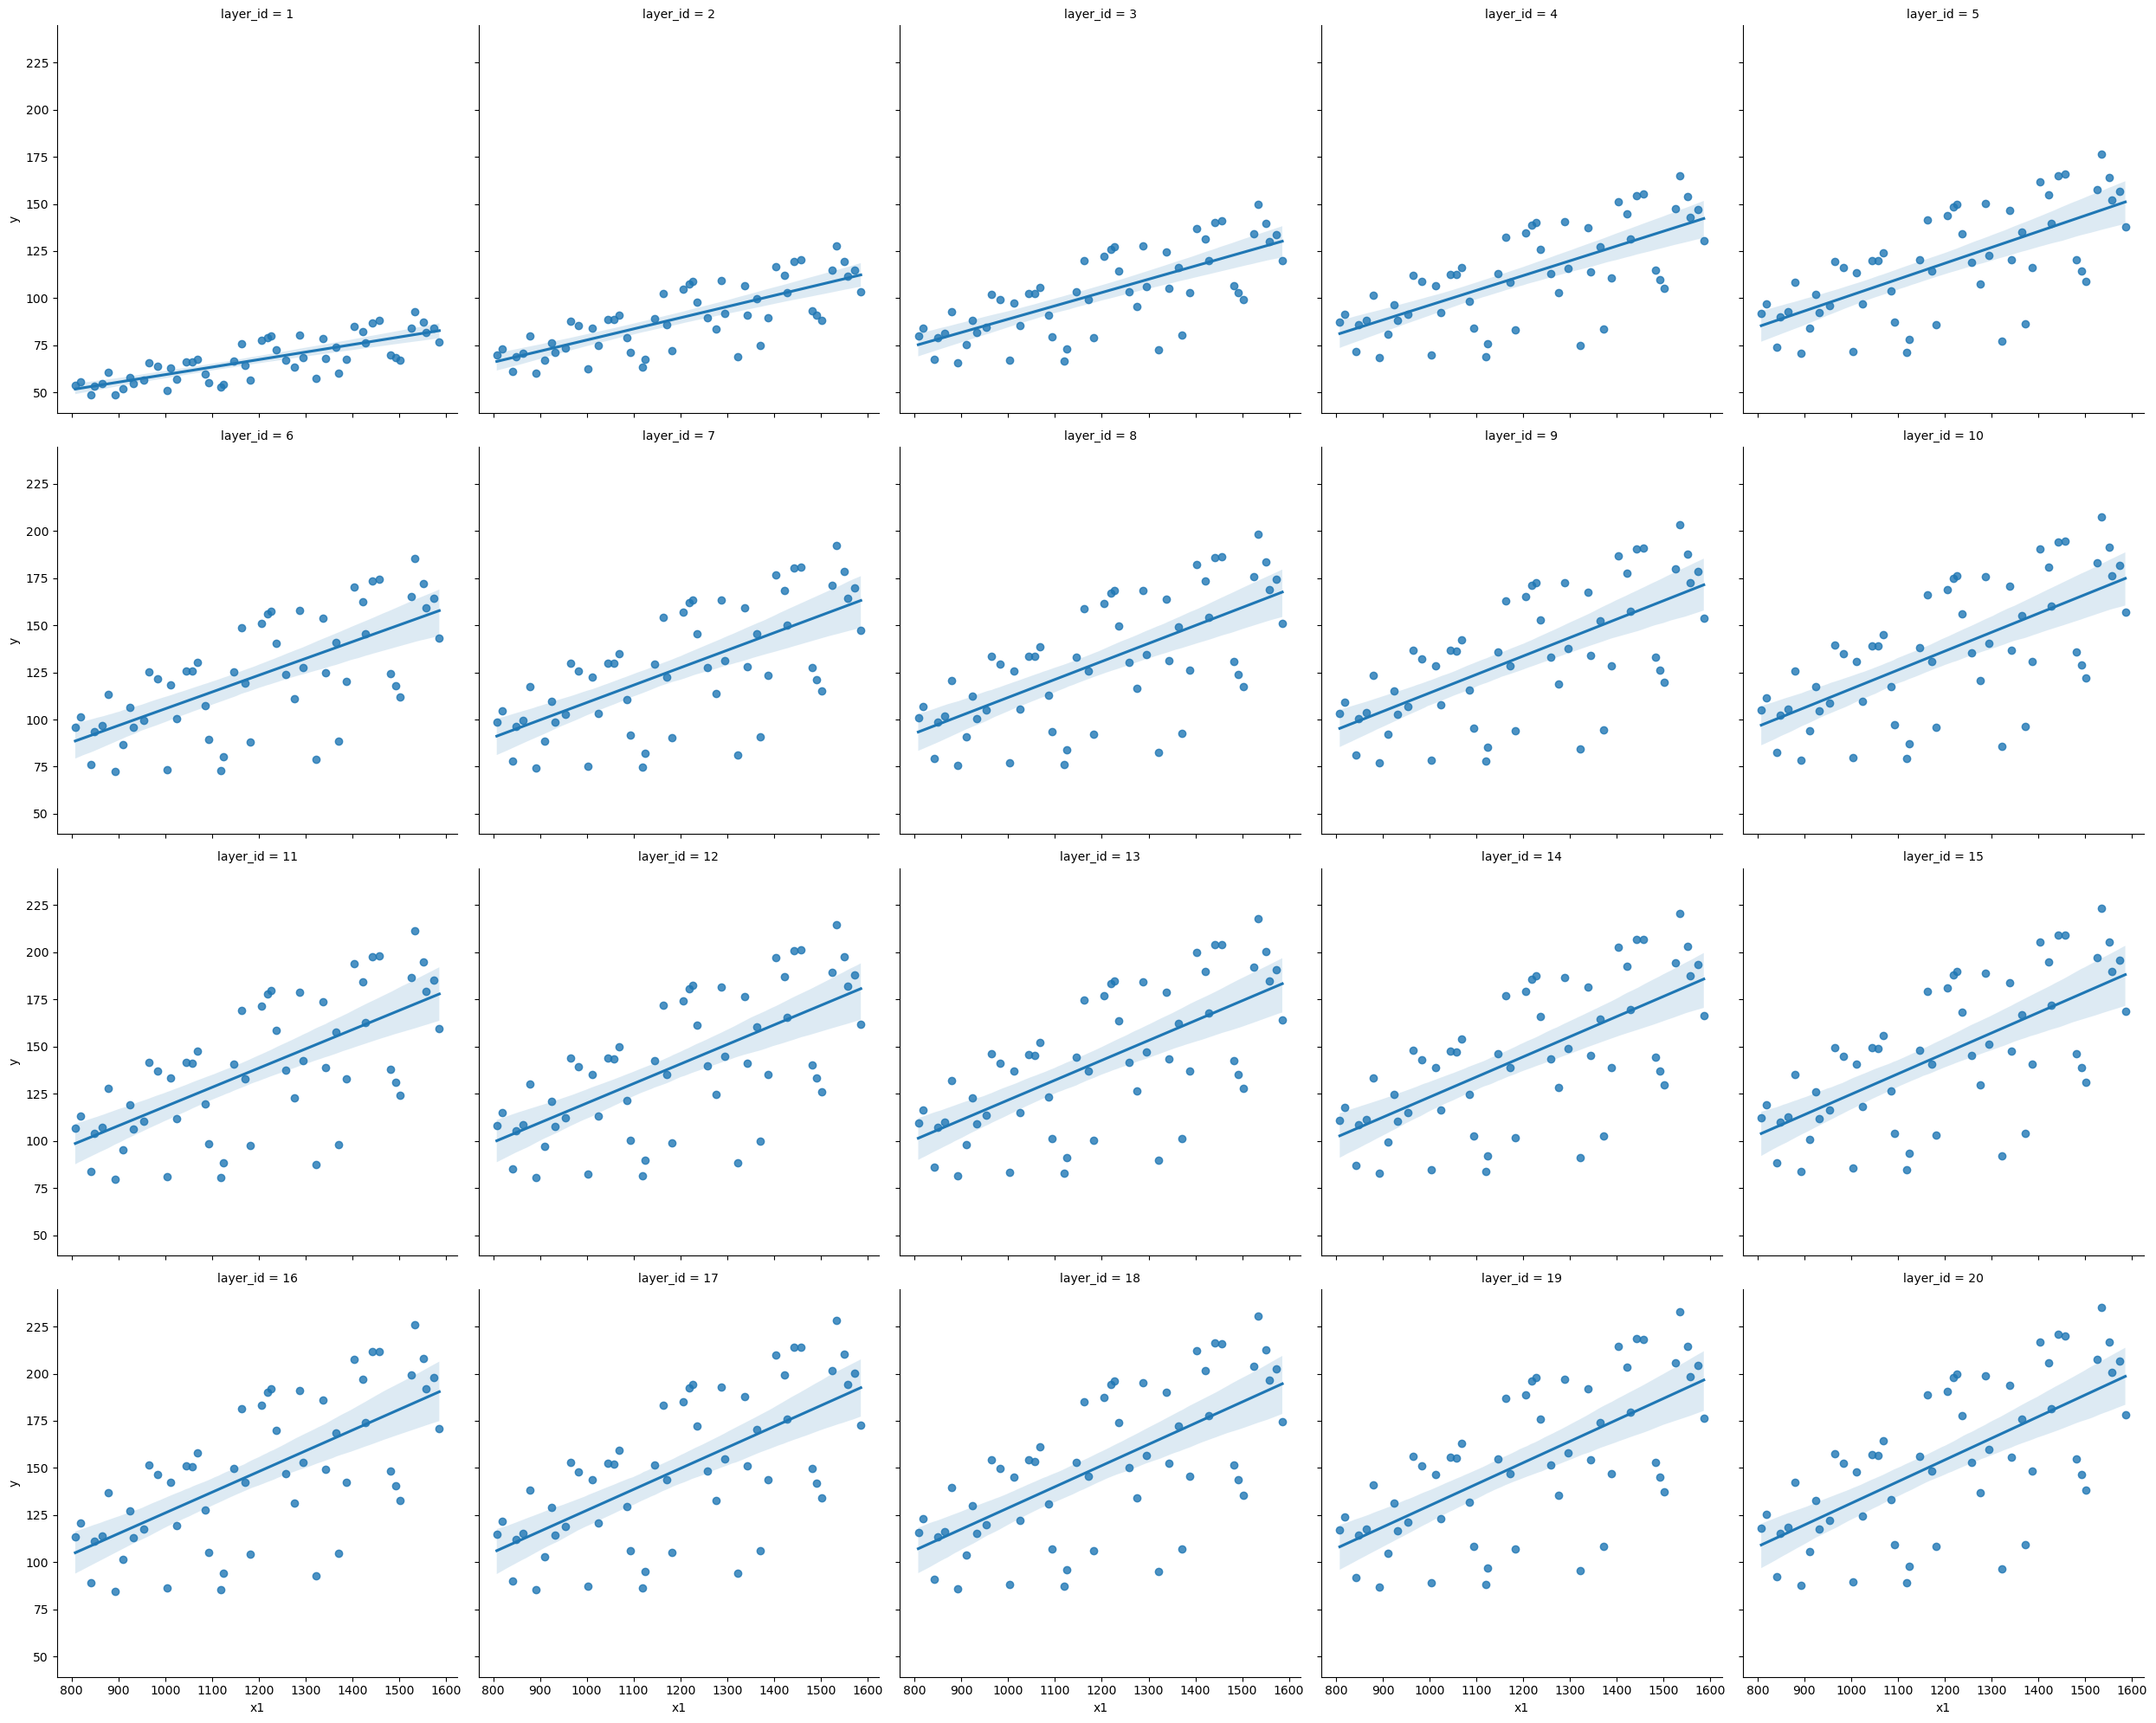

In [50]:
sns.lmplot(data = df.loc[ df.action_id == 3, :],
           x='x1', y = 'y',
           col='layer_id', col_wrap=5)

plt.show()

We can include additional variables as well. For example, let's color the scatter plot markers by `x2`. Can you identify how both `x1` and `x2` influence `y` for a single layer?

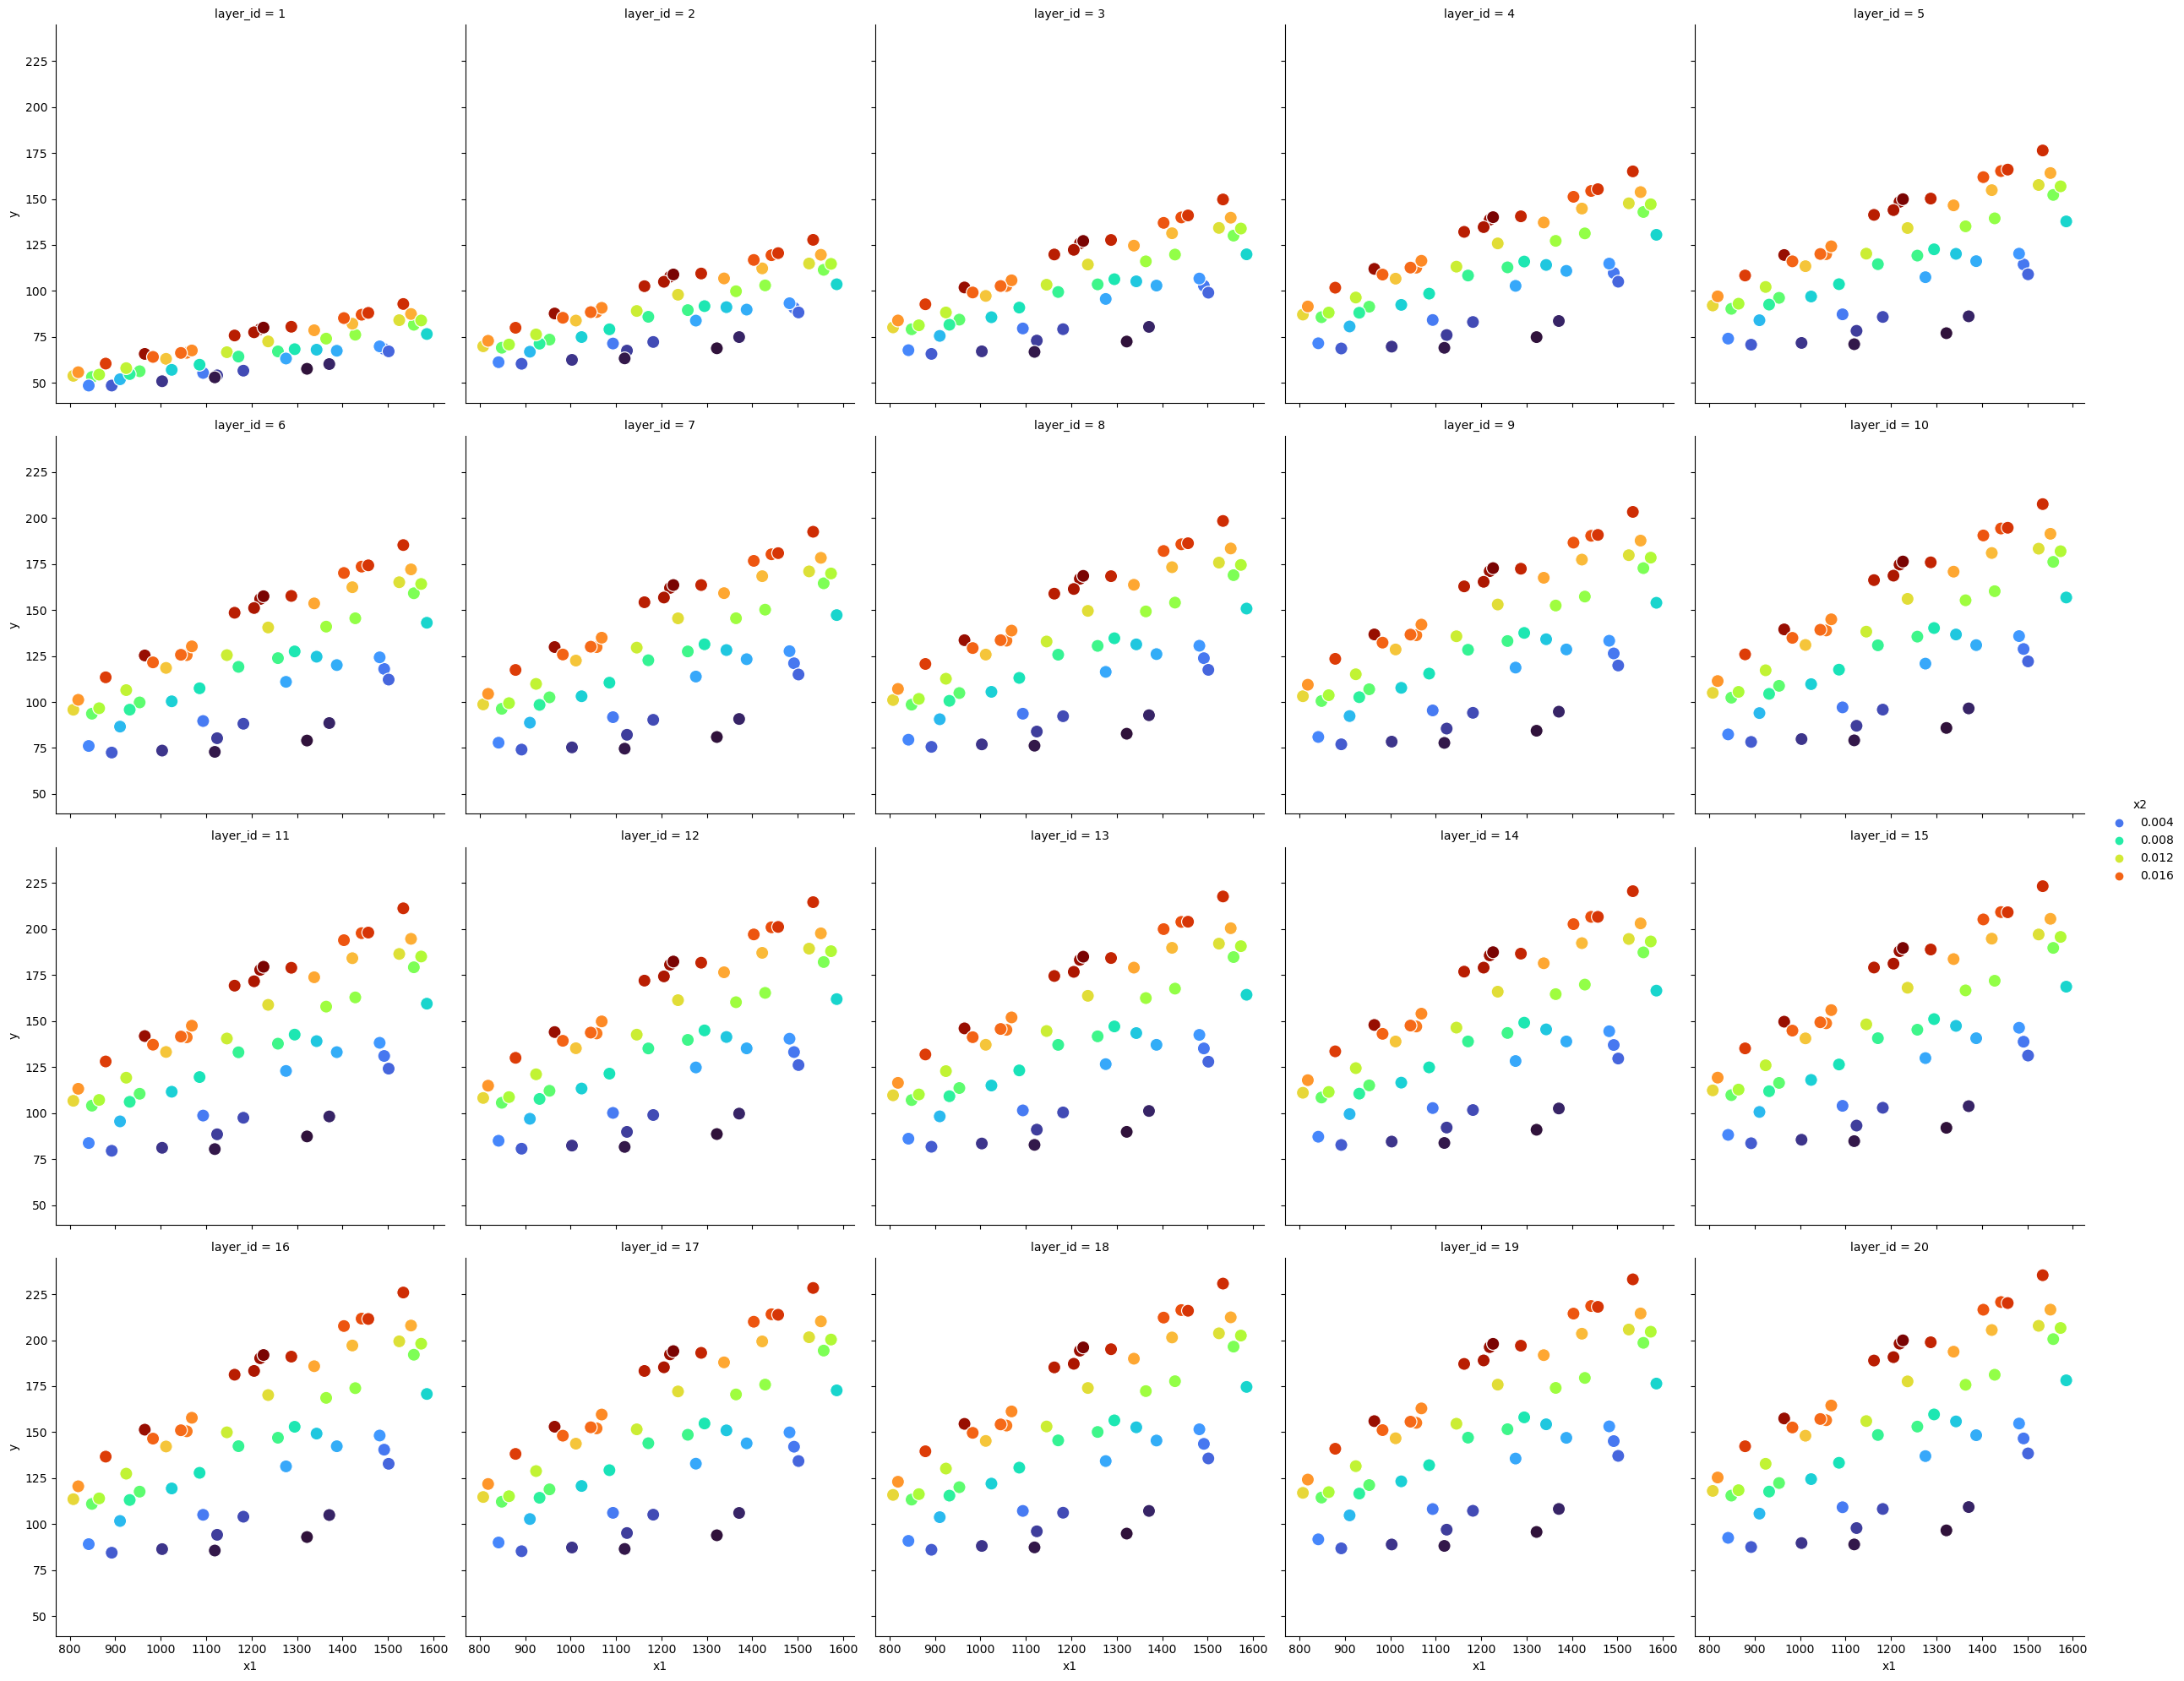

In [51]:
sns.relplot(data = df.loc[ df.action_id == 3, :],
            x='x1', y = 'y',
            hue='x2', palette='turbo',
            kind='scatter', s=120,
            col='layer_id', col_wrap=5)

plt.show()

There are of course many more visualizations that can be created. This demonstrates a few plots in order to focus on the necessary data structure. You are allowed to simplify things by filtering the data to just `action_id = 3`. This way you do not have to keep filtering the data in-line to create the figures.

In [52]:
df_action_3 = df.loc[ df.action_id == 3, :].copy()

## Long and wide formats

However, it is important to note that you **should not** use the merged data to study the input distributions or input-to-input relationships. The merged data use the structure of the larger output data. Thus, the inputs are repeated across many rows. As shown previously, each input value is repeated 60 times in the merged data. 

This repetition enables creating the visualizations shown previously, but this long-format structure does not support models to predict a SINGLE output. The reason why is subtle, but one observation does not correspond to a single instance in time within a layer. One observation corresponds to a single SIMULATION. The observation therefore consists of MULTIPLE output values per observation! The long-format structure is flexible and makes it easy to store the multiple outputs generated by a single simulation. However, most modeling approaches require wide-format data! Thus, models and analysis methods require reshaping the data!  

This section demonstrates how to reshape the output at `action_id = 3` from long-format to wide-format. As a reminder, the merged data filtered to `action_id = 3` is shown below. 

In [53]:
df_action_3

,sim_id,layer_id,action_id,time,y,x1,x2,x3,x4
2,1,1,3,12.9466,76.1949,1428.262963,0.010276,76.449325,22.963241
5,1,2,3,25.8933,103.0120,1428.262963,0.010276,76.449325,22.963241
8,1,3,3,38.8399,119.7640,1428.262963,0.010276,76.449325,22.963241
11,1,4,3,51.7866,131.2680,1428.262963,0.010276,76.449325,22.963241
14,1,5,3,64.7332,139.4440,1428.262963,0.010276,76.449325,22.963241
...,...,...,...,...,...,...,...,...,...
3287,9,16,3,207.0720,142.3440,1387.548586,0.005605,63.950159,28.052451
3290,9,17,3,220.0130,143.9340,1387.548586,0.005605,63.950159,28.052451
3293,9,18,3,232.9550,145.4510,1387.548586,0.005605,63.950159,28.052451
3296,9,19,3,245.8970,146.9260,1387.548586,0.005605,63.950159,28.052451


The reshaping operation we need to do will "swing" or *pivot* the `y` values to separate column values *spread* along a single row. Thus, we want the new wide-format columns to correspond to the layer the temperature is measured at within a single simulation. The reshaped wide-format data will therefore have as many rows as the `input_df` data set!

If we reshape the `df_action_3` DataFrame as it is, the new column names will correspond to integer values. The first few rows of the reshaped wide-format data are shown below.

In [54]:
df_action_3.pivot(index=['sim_id'], columns=['layer_id'], values=['y']).head()

y                                                              \
layer_id       1         2         3         4         5         6         7    
sim_id                                                                          
1         76.1949  103.0120  119.7640  131.2680  139.4440  145.5020  150.1930   
2         53.0233   63.3286   66.8751   69.0819   71.0437   72.9099   74.6423   
3         51.9845   66.9522   75.5616   80.6815   84.0707   86.6271   88.7592   
4         67.1221   89.5724  103.5690  112.8130  119.2040  123.8510  127.4830   
5         67.6415   90.7968  105.7640  116.3840  124.2490  130.2390  134.9520   

                                                                      \
layer_id        8         9         10        11        12        13   
sim_id                                                                 
1         154.0210  157.3040  160.2300  162.8790  165.3330  167.6440   
2          76.2644   77.7799   79.1625   80.4293   81.6152   82.7253   
3          90.6303   92.3632   93.9778   95.4963   96.9034   98.2209   
4         130.5030  133.1390  135.5370  137.7270  139.7860  141.7170   
5         138.8060  142.0670  144.9330  147.4920  149.8300  151.9980   

                                                                                
layer_id        14        15        16        17        18        19        20  
sim_id                                                                          
1         169.8390  171.9270  173.9290  175.8540  177.6970  179.4810  181.2080  
2          83.7672   84.7498   85.6757   86.5374   87.3799   88.1934   88.9853  
3          99.4605  100.6200  101.7350  102.7860  103.8000  104.7840  105.7300  
4         143.5510  145.3090  146.9790  148.5850  150.1140  151.6030  153.0410  
5         154.0360  155.9730  157.8200  159.5880  161.2840  162.9180  164.4990

I dislike integer or number values as column names. I prefer characters. Thus, we will include a "helper" column in the original long-format data, `layer_name`. This column provides the same information as `layer_id`, but the character `layer_` is included before the number. The number is also "zero padded" and thus single digit layers start with 0's. This forces all layers to consist of 2 digits instead of 1. The `layer_name` column is added below. A list comprehension is used to iterate across all values of `df_action_3.layer_id` to create the label.

In [59]:
df_action_3['layer_name'] = ['layer_%02d' % lid for lid in df_action_3.layer_id]

The first and last few rows in the dataframe are shown below. The `layer_name` follows the values of `layer_id`.

In [61]:
df_action_3

,sim_id,layer_id,action_id,time,y,x1,x2,x3,x4,layer_name
2,1,1,3,12.9466,76.1949,1428.262963,0.010276,76.449325,22.963241,layer_01
5,1,2,3,25.8933,103.0120,1428.262963,0.010276,76.449325,22.963241,layer_02
8,1,3,3,38.8399,119.7640,1428.262963,0.010276,76.449325,22.963241,layer_03
11,1,4,3,51.7866,131.2680,1428.262963,0.010276,76.449325,22.963241,layer_04
14,1,5,3,64.7332,139.4440,1428.262963,0.010276,76.449325,22.963241,layer_05
...,...,...,...,...,...,...,...,...,...,...
3287,9,16,3,207.0720,142.3440,1387.548586,0.005605,63.950159,28.052451,layer_16
3290,9,17,3,220.0130,143.9340,1387.548586,0.005605,63.950159,28.052451,layer_17
3293,9,18,3,232.9550,145.4510,1387.548586,0.005605,63.950159,28.052451,layer_18
3296,9,19,3,245.8970,146.9260,1387.548586,0.005605,63.950159,28.052451,layer_19


As a check, the `layer_name` values are consistent with the `layer_id` values.

In [62]:
df_action_3.groupby(['layer_id', 'layer_name']).size().reset_index(name='num_rows')

,layer_id,layer_name,num_rows
0,1,layer_01,55
1,2,layer_02,55
2,3,layer_03,55
3,4,layer_04,55
4,5,layer_05,55
5,6,layer_06,55
6,7,layer_07,55
7,8,layer_08,55
8,9,layer_09,55
9,10,layer_10,55


We can now execute the reshaping! The resulting wide-format data has one row per simulation and one column per layer.

In [63]:
df_action_3.pivot(index=['sim_id'], columns=['layer_name'], values=['y']).head()

y                                                    \
layer_name layer_01  layer_02  layer_03  layer_04  layer_05  layer_06   
sim_id                                                                  
1           76.1949  103.0120  119.7640  131.2680  139.4440  145.5020   
2           53.0233   63.3286   66.8751   69.0819   71.0437   72.9099   
3           51.9845   66.9522   75.5616   80.6815   84.0707   86.6271   
4           67.1221   89.5724  103.5690  112.8130  119.2040  123.8510   
5           67.6415   90.7968  105.7640  116.3840  124.2490  130.2390   

                                                                        \
layer_name  layer_07  layer_08  layer_09  layer_10  layer_11  layer_12   
sim_id                                                                   
1           150.1930  154.0210  157.3040  160.2300  162.8790  165.3330   
2            74.6423   76.2644   77.7799   79.1625   80.4293   81.6152   
3            88.7592   90.6303   92.3632   93.9778   95.4963   96.9034   
4           127.4830  130.5030  133.1390  135.5370  137.7270  139.7860   
5           134.9520  138.8060  142.0670  144.9330  147.4920  149.8300   

                                                                        \
layer_name  layer_13  layer_14  layer_15  layer_16  layer_17  layer_18   
sim_id                                                                   
1           167.6440  169.8390  171.9270  173.9290  175.8540  177.6970   
2            82.7253   83.7672   84.7498   85.6757   86.5374   87.3799   
3            98.2209   99.4605  100.6200  101.7350  102.7860  103.8000   
4           141.7170  143.5510  145.3090  146.9790  148.5850  150.1140   
5           151.9980  154.0360  155.9730  157.8200  159.5880  161.2840   

                                
layer_name  layer_19  layer_20  
sim_id                          
1           179.4810  181.2080  
2            88.1934   88.9853  
3           104.7840  105.7300  
4           151.6030  153.0410  
5           162.9180  164.4990

The column names are a multiindex consisting of the `y` name and the `layer_name` value.

In [64]:
df_action_3.pivot(index=['sim_id'], columns=['layer_name'], values=['y']).columns

MultiIndex([('y', 'layer_01'),
            ('y', 'layer_02'),
            ('y', 'layer_03'),
            ('y', 'layer_04'),
            ('y', 'layer_05'),
            ('y', 'layer_06'),
            ('y', 'layer_07'),
            ('y', 'layer_08'),
            ('y', 'layer_09'),
            ('y', 'layer_10'),
            ('y', 'layer_11'),
            ('y', 'layer_12'),
            ('y', 'layer_13'),
            ('y', 'layer_14'),
            ('y', 'layer_15'),
            ('y', 'layer_16'),
            ('y', 'layer_17'),
            ('y', 'layer_18'),
            ('y', 'layer_19'),
            ('y', 'layer_20')],
           names=[None, 'layer_name'])

I dislike multiindex and so I prefer to override this with simpler names of just the `layer_name` values. The values are saved as a list below.

In [65]:
layer_name_values = df_action_3.layer_name.value_counts().index.to_list()

In [66]:
layer_name_values

['layer_01',
 'layer_02',
 'layer_19',
 'layer_18',
 'layer_17',
 'layer_16',
 'layer_15',
 'layer_14',
 'layer_13',
 'layer_12',
 'layer_11',
 'layer_10',
 'layer_09',
 'layer_08',
 'layer_07',
 'layer_06',
 'layer_05',
 'layer_04',
 'layer_03',
 'layer_20']

The reshaping is executed in the cell below and assigned to the `wf_action_3` object.

In [67]:
wf_action_3 = df_action_3.copy().pivot(index=['sim_id'], columns=['layer_name'], values=['y'])

In [68]:
wf_action_3.head()

y                                                    \
layer_name layer_01  layer_02  layer_03  layer_04  layer_05  layer_06   
sim_id                                                                  
1           76.1949  103.0120  119.7640  131.2680  139.4440  145.5020   
2           53.0233   63.3286   66.8751   69.0819   71.0437   72.9099   
3           51.9845   66.9522   75.5616   80.6815   84.0707   86.6271   
4           67.1221   89.5724  103.5690  112.8130  119.2040  123.8510   
5           67.6415   90.7968  105.7640  116.3840  124.2490  130.2390   

                                                                        \
layer_name  layer_07  layer_08  layer_09  layer_10  layer_11  layer_12   
sim_id                                                                   
1           150.1930  154.0210  157.3040  160.2300  162.8790  165.3330   
2            74.6423   76.2644   77.7799   79.1625   80.4293   81.6152   
3            88.7592   90.6303   92.3632   93.9778   95.4963   96.9034   
4           127.4830  130.5030  133.1390  135.5370  137.7270  139.7860   
5           134.9520  138.8060  142.0670  144.9330  147.4920  149.8300   

                                                                        \
layer_name  layer_13  layer_14  layer_15  layer_16  layer_17  layer_18   
sim_id                                                                   
1           167.6440  169.8390  171.9270  173.9290  175.8540  177.6970   
2            82.7253   83.7672   84.7498   85.6757   86.5374   87.3799   
3            98.2209   99.4605  100.6200  101.7350  102.7860  103.8000   
4           141.7170  143.5510  145.3090  146.9790  148.5850  150.1140   
5           151.9980  154.0360  155.9730  157.8200  159.5880  161.2840   

                                
layer_name  layer_19  layer_20  
sim_id                          
1           179.4810  181.2080  
2            88.1934   88.9853  
3           104.7840  105.7300  
4           151.6030  153.0410  
5           162.9180  164.4990

The column names are modified below.

In [69]:
wf_action_3.columns = layer_name_values

In [70]:
wf_action_3.head()

,layer_01,layer_02,layer_19,layer_18,layer_17,layer_16,layer_15,layer_14,layer_13,layer_12,layer_11,layer_10,layer_09,layer_08,layer_07,layer_06,layer_05,layer_04,layer_03,layer_20
sim_id,,,,,,,,,,,,,,,,,,,,
1,76.1949,103.0120,119.7640,131.2680,139.4440,145.5020,150.1930,154.0210,157.3040,160.2300,162.8790,165.3330,167.6440,169.8390,171.9270,173.9290,175.8540,177.6970,179.4810,181.2080
2,53.0233,63.3286,66.8751,69.0819,71.0437,72.9099,74.6423,76.2644,77.7799,79.1625,80.4293,81.6152,82.7253,83.7672,84.7498,85.6757,86.5374,87.3799,88.1934,88.9853
3,51.9845,66.9522,75.5616,80.6815,84.0707,86.6271,88.7592,90.6303,92.3632,93.9778,95.4963,96.9034,98.2209,99.4605,100.6200,101.7350,102.7860,103.8000,104.7840,105.7300
4,67.1221,89.5724,103.5690,112.8130,119.2040,123.8510,127.4830,130.5030,133.1390,135.5370,137.7270,139.7860,141.7170,143.5510,145.3090,146.9790,148.5850,150.1140,151.6030,153.0410
5,67.6415,90.7968,105.7640,116.3840,124.2490,130.2390,134.9520,138.8060,142.0670,144.9330,147.4920,149.8300,151.9980,154.0360,155.9730,157.8200,159.5880,161.2840,162.9180,164.4990


Resetting the index now creates a "regular" DataFrame which includes `sim_id` as a column!

In [71]:
wf_action_3.reset_index().head()

,sim_id,layer_01,layer_02,layer_19,layer_18,layer_17,layer_16,layer_15,layer_14,layer_13,...,layer_11,layer_10,layer_09,layer_08,layer_07,layer_06,layer_05,layer_04,layer_03,layer_20
0,1,76.1949,103.0120,119.7640,131.2680,139.4440,145.5020,150.1930,154.0210,157.3040,...,162.8790,165.3330,167.6440,169.8390,171.9270,173.9290,175.8540,177.6970,179.4810,181.2080
1,2,53.0233,63.3286,66.8751,69.0819,71.0437,72.9099,74.6423,76.2644,77.7799,...,80.4293,81.6152,82.7253,83.7672,84.7498,85.6757,86.5374,87.3799,88.1934,88.9853
2,3,51.9845,66.9522,75.5616,80.6815,84.0707,86.6271,88.7592,90.6303,92.3632,...,95.4963,96.9034,98.2209,99.4605,100.6200,101.7350,102.7860,103.8000,104.7840,105.7300
3,4,67.1221,89.5724,103.5690,112.8130,119.2040,123.8510,127.4830,130.5030,133.1390,...,137.7270,139.7860,141.7170,143.5510,145.3090,146.9790,148.5850,150.1140,151.6030,153.0410
4,5,67.6415,90.7968,105.7640,116.3840,124.2490,130.2390,134.9520,138.8060,142.0670,...,147.4920,149.8300,151.9980,154.0360,155.9730,157.8200,159.5880,161.2840,162.9180,164.4990


Let's reset the index and modify in place.

In [72]:
wf_action_3.reset_index(inplace=True)

We now have the wide-format `y` values where 1 row is one simulation and one column is the `y` value at a layer measured at `action_id = 3`!

In [75]:
wf_action_3.head()

,sim_id,layer_01,layer_02,layer_19,layer_18,layer_17,layer_16,layer_15,layer_14,layer_13,...,layer_11,layer_10,layer_09,layer_08,layer_07,layer_06,layer_05,layer_04,layer_03,layer_20
0,1,76.1949,103.0120,119.7640,131.2680,139.4440,145.5020,150.1930,154.0210,157.3040,...,162.8790,165.3330,167.6440,169.8390,171.9270,173.9290,175.8540,177.6970,179.4810,181.2080
1,2,53.0233,63.3286,66.8751,69.0819,71.0437,72.9099,74.6423,76.2644,77.7799,...,80.4293,81.6152,82.7253,83.7672,84.7498,85.6757,86.5374,87.3799,88.1934,88.9853
2,3,51.9845,66.9522,75.5616,80.6815,84.0707,86.6271,88.7592,90.6303,92.3632,...,95.4963,96.9034,98.2209,99.4605,100.6200,101.7350,102.7860,103.8000,104.7840,105.7300
3,4,67.1221,89.5724,103.5690,112.8130,119.2040,123.8510,127.4830,130.5030,133.1390,...,137.7270,139.7860,141.7170,143.5510,145.3090,146.9790,148.5850,150.1140,151.6030,153.0410
4,5,67.6415,90.7968,105.7640,116.3840,124.2490,130.2390,134.9520,138.8060,142.0670,...,147.4920,149.8300,151.9980,154.0360,155.9730,157.8200,159.5880,161.2840,162.9180,164.4990


In [73]:
wf_action_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sim_id    55 non-null     int64  
 1   layer_01  55 non-null     float64
 2   layer_02  55 non-null     float64
 3   layer_19  55 non-null     float64
 4   layer_18  55 non-null     float64
 5   layer_17  55 non-null     float64
 6   layer_16  55 non-null     float64
 7   layer_15  55 non-null     float64
 8   layer_14  55 non-null     float64
 9   layer_13  55 non-null     float64
 10  layer_12  55 non-null     float64
 11  layer_11  55 non-null     float64
 12  layer_10  55 non-null     float64
 13  layer_09  55 non-null     float64
 14  layer_08  55 non-null     float64
 15  layer_07  55 non-null     float64
 16  layer_06  55 non-null     float64
 17  layer_05  55 non-null     float64
 18  layer_04  55 non-null     float64
 19  layer_03  55 non-null     float64
 20  layer_20  55 non-null     float64


The inputs can be joined to the wide-format data by joining on the `sim_id` column.

### PCA and clustering

Before fitting predictive models, you must use PCA to help identify clusters in the data. You must cluster the simulations based on the PC scores instead of clustering based on the `y` values. As mentioned previously, one observation is a simulation. The simulation produces multiple outputs. You should explore the patterns based on the behavior of the all outputs across the simulations! You must focus on the behavior associated with `action_id = 3`.  

However, just why should you use PC scores instead of the reshaped wide-format `y` values? The correlation plot created below shows why. The outputs are **highly correlated**!!! The figure below looks like a giant red square because the `y` values across the layers are highly correlated with each other! 

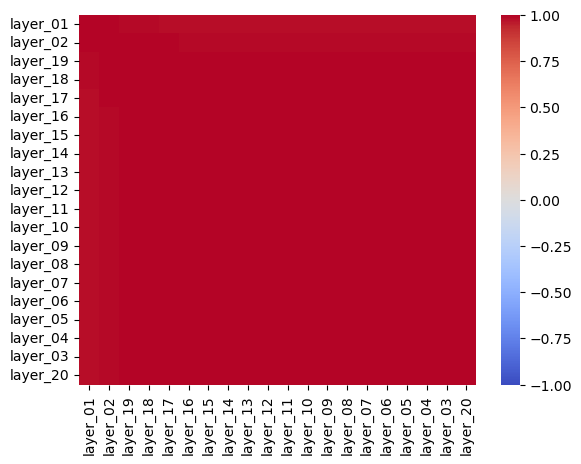

In [76]:
fig, ax = plt.subplots()

sns.heatmap(wf_action_3.drop(columns=['sim_id']).corr(),
            vmin=-1, center=0, vmax=1,
            cmap='coolwarm',
            ax=ax)

plt.show()

The above correlation plot might be overwhelming. The cell below creates a correlation plot but just using layers 1, 10, and 20  to confirm the layers are indeed that highly correlated.

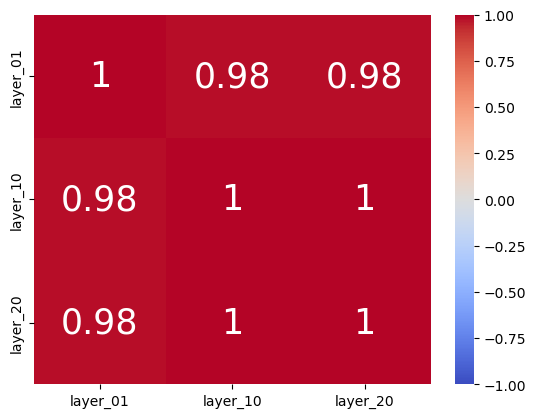

In [77]:
fig, ax = plt.subplots()

sns.heatmap(wf_action_3.loc[:, ['layer_01', 'layer_10', 'layer_20']].corr(),
            vmin=-1, center=0, vmax=1,
            cmap='coolwarm',
            annot=True, annot_kws={'size': 25},
            ax=ax)

plt.show()

This very high correlation means that when the output in layer 1 increases, all other layers increase as well!

You must decide the number of PCs to use for clustering. You should visualize the histograms of the PC scores and visualize the scatter plot between those PC scores.

## Predictive modeling recommendations

There are several ways to go about training models for this application. The most challenging approach is to predict the output *trajectory* based on the inputs. The output *trajectory* corresponds to the output `y` at all 20 layers. Thus, the challenging approach treats the problem as a **multi-output** problem. One way to manage this is to use PCA. You can train regression models to predict the PC scores as a function of the inputs and then **reconstruct** the original outputs from the PC scores. This challenging approach therefore requires several matrix multiplication procedures we do not discuss in CMPINF 2100. You will be introduced to how to do this in CMPINF 2120.

However, the problem can be studied using the methods demonstrated in CMPINF 2100. The output must be summarized so that you can focus on a single output from the output trajectory. For example, you may predict the **average** `y` value for `action_id = 3`, or the **maximum** `y` value for `action_id = 3`. You may also predict other summary statistics such as the `range` (difference between maximum and minimum value) or standard deviation. This strategy therefore focuses on predicting **summary statistics** of the output, `y`, per simulation based on the input. This is a useful starting point even if you want to ultimately try the more challenging multi-output approach with PCA.

It is important to note that the summary statistics are associated with summarizing within a single simulation and not across simulations. It is critical to focus on a single action, `action_id = 3`, and apply the desired summary functions to the `y` variable grouped by `sim_id`.  

The cell below demonstrates this grouping to calculate the min and max `y` values per simulation. The result is assigned to the `output_sim_summary` object. You must modify the cell below if you want to study the average output per simulation.

In [78]:
output_sim_summary = df_action_3.\
groupby(['sim_id']).\
aggregate(y_min = ('y', 'min'),
          y_max = ('y', 'max')).\
reset_index()

In [79]:
output_sim_summary.head()

,sim_id,y_min,y_max
0,1,76.1949,181.2080
1,2,53.0233,88.9853
2,3,51.9845,105.7300
3,4,67.1221,153.0410
4,5,67.6415,164.4990


The range of `y` per simulation is calculated below.

In [80]:
output_sim_summary['y_range'] = output_sim_summary.y_max - output_sim_summary.y_min

In [81]:
output_sim_summary.head()

,sim_id,y_min,y_max,y_range
0,1,76.1949,181.2080,105.0131
1,2,53.0233,88.9853,35.9620
2,3,51.9845,105.7300,53.7455
3,4,67.1221,153.0410,85.9189
4,5,67.6415,164.4990,96.8575


The inputs can be joined to `output_sim_summary` on the `sim_id` column to allow exploring the relationships between the desired summary statistics and the inputs.  

This approach is simpler than predicting the complete output trajectory. However, it highlights that quite often we must **summarize** a larger data set **before** we can starting training models. This is quite common in practice and often times serves as a useful starting point for a larger more challenging task of predicting *trajectories*.